# 🏀 College Basketball Scoring Analytics
## ESPN Top 500 Scorers — 2025-26 NCAA Season

**Author:** Analytics Consulting  
**Data Source:** ESPN Men's College Basketball (web-scraped 2026-02-23)  
**Dataset:** 500 players ranked by Points Per Game (PPG) across 305 programs  
**Tools:** Python · pandas · scikit-learn · matplotlib

---

## Project Overview

This notebook presents two complementary analytics projects built on the same ESPN dataset. Together they make the case that **the box score is a starting point, not a conclusion.**

| # | Project | Core Question | Method |
|---|---------|--------------|--------|
| 1 | **Scoring Archetypes** | *How do elite scorers differ in **how** they produce points?* | K-Means Clustering + PCA |
| 2 | **Scoring Efficiency Index** | *Which high scorers are overrated — and who is flying under the radar?* | Composite Z-Score + Rank Delta |

### Analytical Thread

Project 1 follows a deliberate two-stage methodology:

1. **Run the statistics honestly.** Let the elbow method and silhouette score select the optimal cluster count without interference. Document what they return and why.
2. **Apply domain knowledge.** Evaluate whether the statistical optimum actually serves the analytical goal. If not, override it — transparently — and explain the trade-off.

This approach is central to the write-up: a good analyst knows when to follow the algorithm and when to lead it.

---

> *All outputs (charts, enriched CSV) are reproducible by running this notebook top-to-bottom.*  
> *Place `cbb_players.csv` in the same directory before running.*

## 0 · Setup

All styling constants are centralised here so the dark-theme palette is consistent across every chart in the notebook. Adjust once, propagates everywhere.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# ── Dark theme palette ────────────────────────────────────────────────────────
BG        = '#0D1117'   # near-black canvas
PANEL     = '#161B22'   # chart panel
GRID      = '#21262D'   # grid lines
TEXT      = '#E6EDF3'   # primary text
MUTED     = '#8B949E'   # secondary text
ACCENT    = '#58A6FF'   # blue
HIGHLIGHT = '#F0883E'   # orange

# k=2 archetype colors
K2_COLORS = ['#FF7B72', '#58A6FF']

# k=4 archetype colors (used from Section 1.3 onward)
ARCHETYPE_COLORS = {
    'Paint Dominators':     '#FF7B72',
    'Shot Creators':        '#F0883E',
    'Versatile Playmakers': '#3FB950',
    'Perimeter Snipers':    '#58A6FF',
}

plt.rcParams.update({
    'figure.facecolor': BG,  'axes.facecolor': PANEL,
    'axes.edgecolor':  GRID, 'axes.labelcolor': TEXT,
    'axes.titlecolor': TEXT, 'xtick.color': MUTED,
    'ytick.color':    MUTED, 'text.color': TEXT,
    'grid.color':     GRID,  'grid.linewidth': 0.6,
    'font.family':    'DejaVu Sans', 'figure.dpi': 150,
})

print('Setup complete.')

c:\Users\justi\anaconda3\envs\anly656\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Setup complete.


## 1 · Data Loading & Feature Engineering

### 1.1 Raw Features (from ESPN)
The scraped dataset contains standard box-score stats per player: `PTS`, `FGM/FGA`, `3PM/3PA`, `FTM/FTA`, `REB`, `AST`, `STL`, `BLK`, `TO`, `MIN`, `GP`.

### 1.2 Derived Features
Five additional metrics are engineered before any modelling. Each formula is documented so the analysis is fully reproducible:

| Feature | Formula | Purpose |
|---------|---------|--------|
| `3PA_rate` | 3PA / FGA | Share of attempts from 3-point range — perimeter orientation |
| `FTA_rate` | FTA / FGA | Free-throw attempts per field-goal attempt — rim aggression / foul-drawing |
| `TS_pct` | PTS / (2 × (FGA + 0.44 × FTA)) | True Shooting % — the composite efficiency gold standard |
| `PPM` | PTS / MIN | Scoring output per minute — controls for playing time |
| `AST_TO` | AST / TO | Assist-to-turnover ratio — playmaking discipline |

> **Note on the 0.44 multiplier in TS%:** This is the universally accepted approximation for converting free-throw attempts into possession cost. It accounts for the fact that most FT opportunities come in pairs, with some single-shot scenarios (and-ones, technicals) pulling the effective rate below 0.5.


In [2]:
df = pd.read_csv('espn-cbb top players ppg-2026-02-23.csv')

# ── Feature engineering ───────────────────────────────────────────────────────
df['3PA_rate'] = df['3PA']  / df['FGA']
df['FTA_rate'] = df['FTA']  / df['FGA']
df['TS_pct']   = df['PTS']  / (2 * (df['FGA'] + 0.44 * df['FTA']))
df['PPM']      = df['PTS']  / df['MIN']
df['AST_TO']   = df['AST']  / df['TO'].replace(0, 0.1)  # guard against div-by-zero
df['Position'] = df['Position'].replace('PG', 'G')       # normalise position labels

print(f'Loaded: {len(df)} players | {df["College"].nunique()} programs | '
      f'{df["Position"].nunique()} position groups')
print(f'PPG range    : {df["PTS"].min():.1f} – {df["PTS"].max():.1f}')
print(f'TS%  range   : {df["TS_pct"].min():.3f} – {df["TS_pct"].max():.3f}')
print(f'3PA rate range: {df["3PA_rate"].min():.3f} – {df["3PA_rate"].max():.3f}')
print()
df[['Name','College','Position','PTS','TS_pct','PPM','AST_TO','3PA_rate','FTA_rate']].head(10)

Loaded: 500 players | 305 programs | 3 position groups
PPG range    : 13.5 – 24.9
TS%  range   : 0.462 – 0.727
3PA rate range: 0.000 – 0.810



,Name,College,Position,PTS,TS_pct,PPM,AST_TO,3PA_rate,FTA_rate
0,AJ Dybantsa,BYU,F,24.9,0.630699,0.738872,1.379310,0.237500,0.531250
1,Jordan Riley,ECU,G,23.6,0.505310,0.624339,0.920000,0.177665,0.421320
2,P.J. Haggerty,KSU,G,23.5,0.566320,0.673352,1.181818,0.213483,0.376404
3,Daeshun Ruffin,JKST,G,23.5,0.576772,0.699405,1.435897,0.272727,0.533333
4,Cameron Boozer,DUKE,F,22.6,0.673742,0.689024,1.739130,0.264286,0.450000
5,Nick Martinelli,NU,F,22.3,0.609556,0.638968,1.133333,0.215686,0.444444
6,Ebuka Okorie,STAN,G,22.3,0.576406,0.646377,1.941176,0.368750,0.475000
7,Darius Acuff Jr.,ARK,G,22.2,0.623596,0.641618,3.263158,0.358974,0.320513
8,Josh Hubbard,MSST,G,22.0,0.552875,0.664653,1.565217,0.497110,0.341040
9,Dominique Daniels Jr.,CBU,G,22.0,0.535645,0.606061,1.375000,0.308571,0.394286


---
# Project 1 — Scoring Archetypes via K-Means Clustering

## Objective
Identify distinct *types* of scorers by clustering players on **how they produce points**, not how many. A player scoring 20 PPG by bombing threes is a fundamentally different asset from one earning 20 at the free-throw line by attacking the paint.

## Features Selected
We deliberately choose shot-profile and efficiency features — not raw volume — so that clusters reflect scoring *style*, not scoring *quantity*:

```
3PA_rate  · FTA_rate  · FGPct  · 3PPct  · FTPct  · TS_pct
```

All features are **z-score standardised** before clustering so no single metric dominates due to scale differences.

## Two-Stage Methodology
This project follows a deliberate two-stage approach:

- **Stage 1 (Section 1.3)** — Run the statistics honestly. Let the elbow method and silhouette score select k without bias. Treat whatever they return as the baseline truth.
- **Stage 2 (Section 1.4)** — Evaluate whether the statistical optimum actually serves the analytical goal. Override if necessary — but document the trade-off explicitly.


### 1.1 · Feature Preparation & Scaling


In [ ]:
cluster_features = ['3PA_rate', 'FTA_rate', 'FGPct', '3PPct', 'FTPct', 'TS_pct']

X = df[cluster_features].copy()
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Cluster features (standardized):')
pd.DataFrame(X_scaled, columns=cluster_features).describe().round(3)

Cluster features (standardised):


,3PA_rate,FTA_rate,FGPct,3PPct,FTPct,TS_pct
count,500.000,500.000,500.000,500.000,500.000,500.000
mean,-0.000,0.000,0.000,0.000,-0.000,0.000
std,1.001,1.001,1.001,1.001,1.001,1.001
min,-2.072,-1.980,-2.101,-3.779,-4.422,-2.656
25%,-0.623,-0.745,-0.740,-0.262,-0.562,-0.655
50%,0.011,-0.145,-0.186,0.170,0.152,-0.050
75%,0.702,0.662,0.510,0.574,0.705,0.612
max,2.425,4.857,4.261,2.873,1.944,3.070


### 1.2 · Selecting k — Elbow Method & Silhouette Score

Before fitting any model we evaluate two complementary criteria across k = 2 through 9:

- **Elbow method (inertia):** Total within-cluster sum of squares. We look for the point of diminishing returns — the 'elbow' — where adding another cluster yields minimal additional compactness.
- **Silhouette score:** Measures how similar each point is to its own cluster vs. neighbouring clusters. Range is −1 to 1; higher means better-separated clusters. The k with the highest silhouette is the statistically optimal choice.

These two methods often agree. When they disagree, the silhouette score is generally the more reliable single criterion.


In [ ]:
inertia    = []
sil_scores = []
k_range    = range(2, 10)

for k in k_range:
    km     = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

k_list     = list(k_range)
best_k     = k_list[np.argmax(sil_scores)]

print(f'  k  |  Inertia   |  Silhouette')
print(f'  ---+-----------+------------')
for k, ine, sil in zip(k_list, inertia, sil_scores):
    marker = '  ← best silhouette' if k == best_k else ''
    print(f'  {k}  |  {ine:8.1f}  |  {sil:.4f}{marker}')

print(f'\nStatistically optimal k: {best_k}')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Stage 1 — Elbow Method & Silhouette Analysis\n'
             'Letting the Data Select the Optimal Cluster Count',
             fontsize=13, fontweight='bold', color=TEXT, y=1.02)

# Elbow
axes[0].plot(k_list, inertia, 'o-', color=ACCENT, linewidth=2.5, markersize=7)
axes[0].axvline(best_k, color=HIGHLIGHT, linestyle='--', alpha=0.7, label=f'Best k={best_k}')
axes[0].set_title('Elbow — Within-Cluster Inertia', color=TEXT, fontsize=11, pad=8)
axes[0].set_xlabel('Number of Clusters (k)', color=MUTED)
axes[0].set_ylabel('Inertia', color=MUTED)
axes[0].legend(facecolor=PANEL, edgecolor=GRID, labelcolor=TEXT)
axes[0].grid(True, alpha=0.35)

# Silhouette
bar_colors = [HIGHLIGHT if k == best_k else ACCENT for k in k_list]
bars = axes[1].bar(k_list, sil_scores, color=bar_colors, edgecolor=BG, width=0.6)
for bar, s in zip(bars, sil_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{s:.3f}', ha='center', fontsize=9, color=TEXT)
axes[1].set_title('Silhouette Score by k\n(Higher = Better-Separated Clusters)',
                  color=TEXT, fontsize=11, pad=8)
axes[1].set_xlabel('Number of Clusters (k)', color=MUTED)
axes[1].set_ylabel('Silhouette Score', color=MUTED)
axes[1].grid(True, alpha=0.35, axis='y')

plt.tight_layout()
plt.show()
print(f'Result: k={best_k} maximises silhouette. This is our Stage 1 baseline.')

### 1.3 · Stage 1 Result — k=2 Analysis

The silhouette score peaks at **k=2**, which is the statistically correct answer. This result has genuine basketball meaning: at the broadest level, college basketball scoring divides cleanly into two fundamental profiles.

We run the full k=2 analysis — scatter plot, radar profiles, and cluster means — before evaluating whether k=2 is sufficient for our analytical purpose.


In [4]:
# ── Fit k=2 ──────────────────────────────────────────────────────────────────
km2      = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_k2 = km2.fit_predict(X_scaled)
df['Cluster_k2'] = labels_k2

# ── PCA for 2-D visualisation ────────────────────────────────────────────────
pca    = PCA(n_components=2, random_state=42)
X_pca  = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]
var_exp = pca.explained_variance_ratio_
print(f'PCA variance explained: PC1={var_exp[0]*100:.1f}%  PC2={var_exp[1]*100:.1f}%  '
      f'Total={sum(var_exp)*100:.1f}%')

# ── Cluster means ─────────────────────────────────────────────────────────────
means_k2 = df.groupby('Cluster_k2')[cluster_features].mean()
means_k2_disp = means_k2.copy()
means_k2_disp['TS_pct']   *= 100
means_k2_disp['3PA_rate'] *= 100
means_k2_disp['FTA_rate'] *= 100

# Auto-label clusters
paint_k2   = means_k2['3PA_rate'].idxmin()   # lowest 3PA → Paint Bruisers
sniper_k2  = means_k2['3PA_rate'].idxmax()   # highest 3PA → Perimeter Snipers
k2_names   = {paint_k2: 'Paint Bruisers', sniper_k2: 'Perimeter Snipers'}
df['Archetype_k2'] = df['Cluster_k2'].map(k2_names)

print('\nk=2 Cluster means:')
display_df = means_k2_disp.copy()
display_df.index = [k2_names[i] for i in display_df.index]
print(display_df.round(2).to_string())
print()
for name in ['Paint Bruisers', 'Perimeter Snipers']:
    n = (df['Archetype_k2'] == name).sum()
    pos = df[df['Archetype_k2']==name]['Position'].value_counts().to_dict()
    print(f'  {name}: {n} players | {pos}')

PCA variance explained: PC1=49.6%  PC2=24.4%  Total=74.0%

k=2 Cluster means:
                   3PA_rate  FTA_rate  FGPct  3PPct  FTPct  TS_pct
Paint Bruisers        16.44     51.52  54.58  26.83  69.60   61.30
Perimeter Snipers     44.31     34.60  44.31  35.97  80.53   57.52

  Paint Bruisers: 125 players | {'F': 72, 'G': 43, 'C': 10}
  Perimeter Snipers: 375 players | {'G': 312, 'F': 62, 'C': 1}


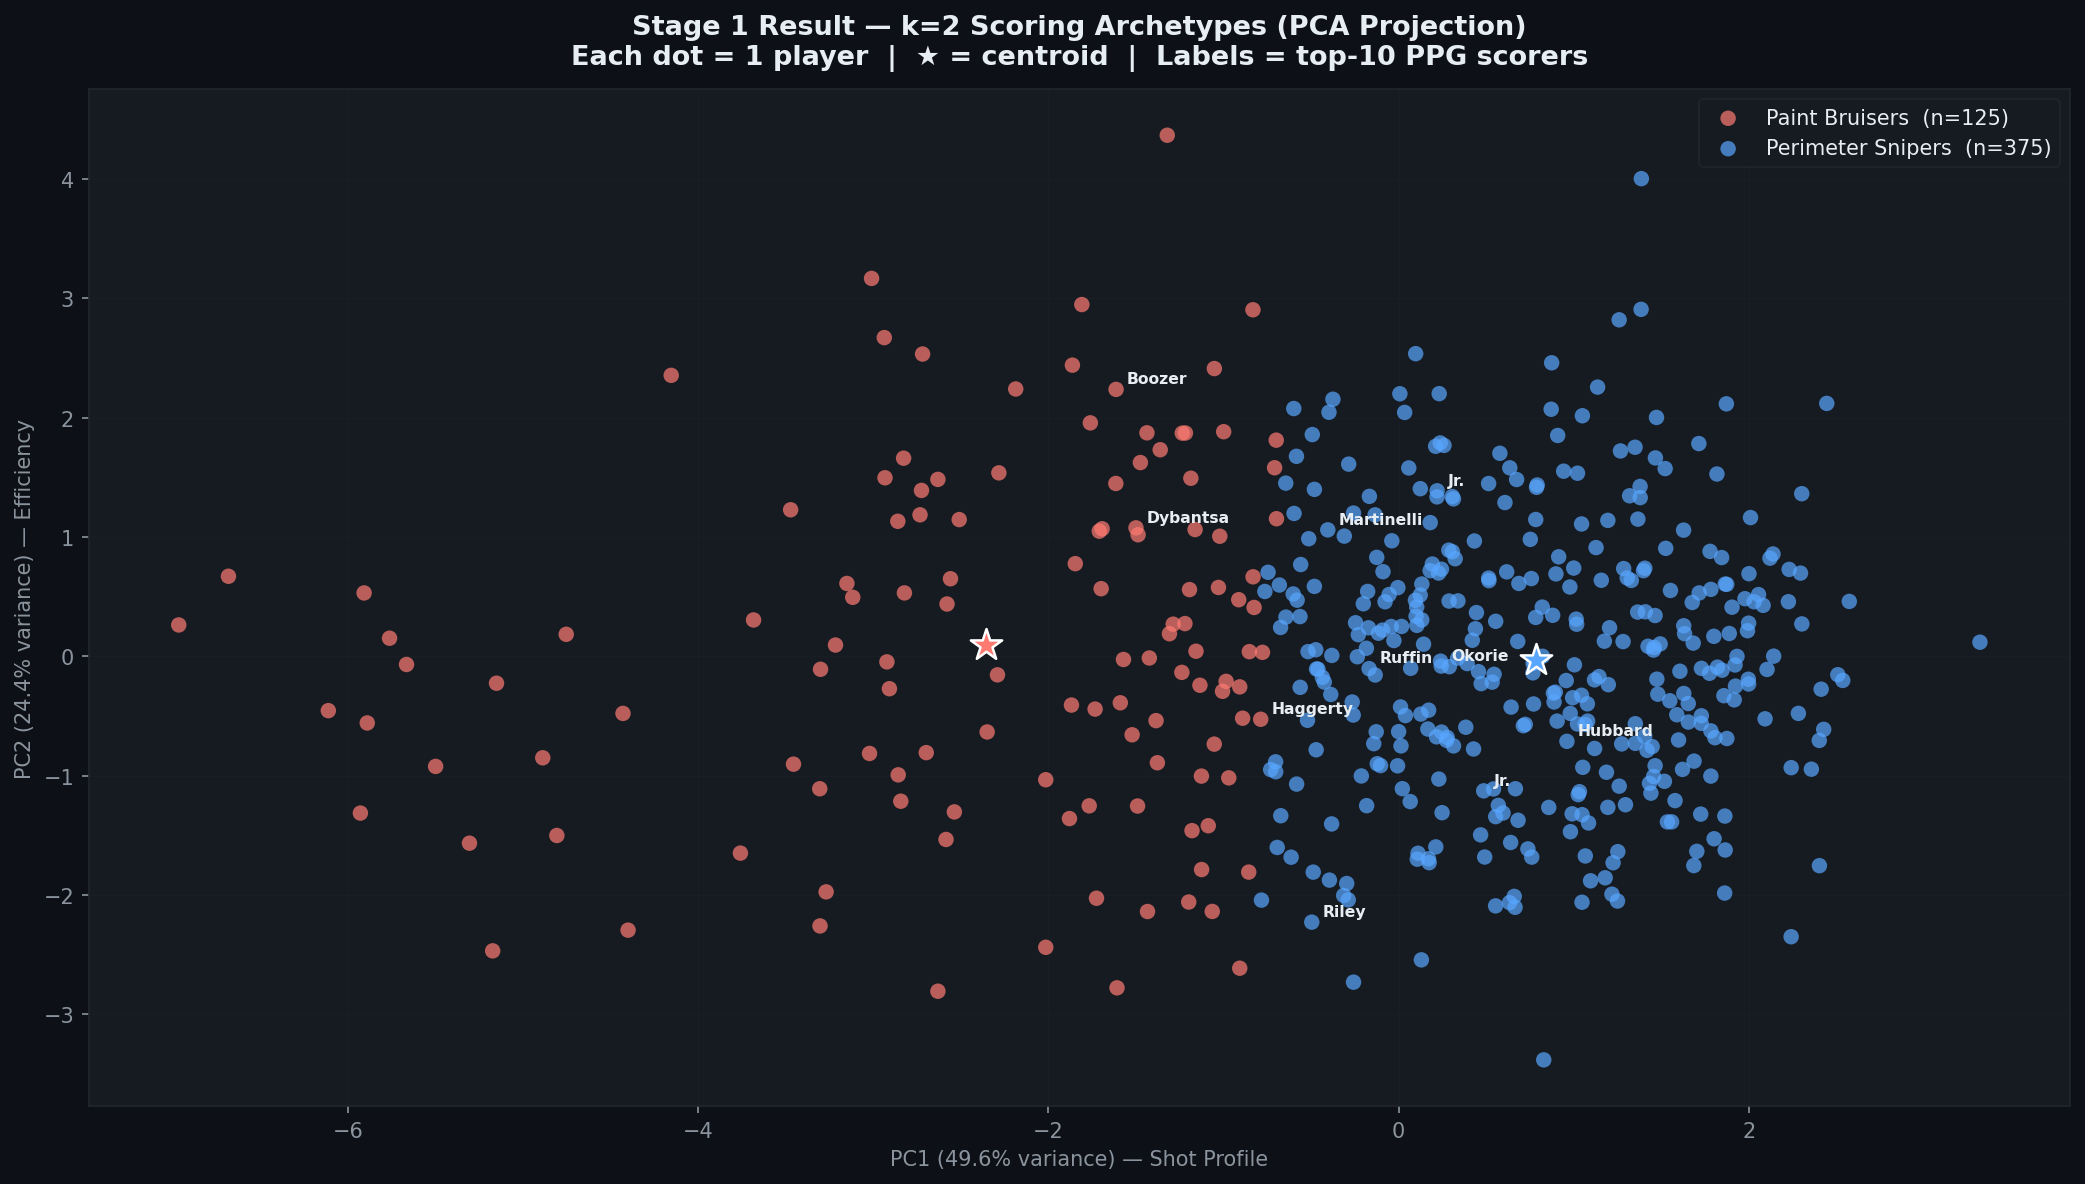

In [5]:
# ── Scatter plot ─────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

k2_color_map = {'Paint Bruisers': K2_COLORS[0], 'Perimeter Snipers': K2_COLORS[1]}
for arch, color in k2_color_map.items():
    mask = df['Archetype_k2'] == arch
    ax.scatter(df.loc[mask,'PCA1'], df.loc[mask,'PCA2'],
               c=color, label=f'{arch}  (n={mask.sum()})',
               s=55, alpha=0.70, edgecolors='none', zorder=3)

# Annotate top 10 PPG
for _, row in df.nlargest(10, 'PTS').iterrows():
    ax.annotate(row['Name'].split()[-1], (row['PCA1'], row['PCA2']),
                fontsize=7.5, color=TEXT, fontweight='bold',
                xytext=(5, 3), textcoords='offset points')

# Centroids
for i, (cx, cy) in enumerate(pca.transform(km2.cluster_centers_)):
    ax.scatter(cx, cy, s=250, marker='*', color=K2_COLORS[i],
               edgecolors='white', linewidths=1.2, zorder=5)

ax.set_title('Stage 1 Result — k=2 Scoring Archetypes (PCA Projection)\n'
             'Each dot = 1 player  |  ★ = centroid  |  Labels = top-10 PPG scorers',
             fontsize=13, fontweight='bold', pad=12)
ax.set_xlabel(f'PC1 ({var_exp[0]*100:.1f}% variance) — Shot Profile', color=MUTED)
ax.set_ylabel(f'PC2 ({var_exp[1]*100:.1f}% variance) — Efficiency', color=MUTED)
ax.grid(True, alpha=0.28)
ax.legend(facecolor=PANEL, edgecolor=GRID, labelcolor=TEXT, fontsize=10)
plt.tight_layout()
plt.show()

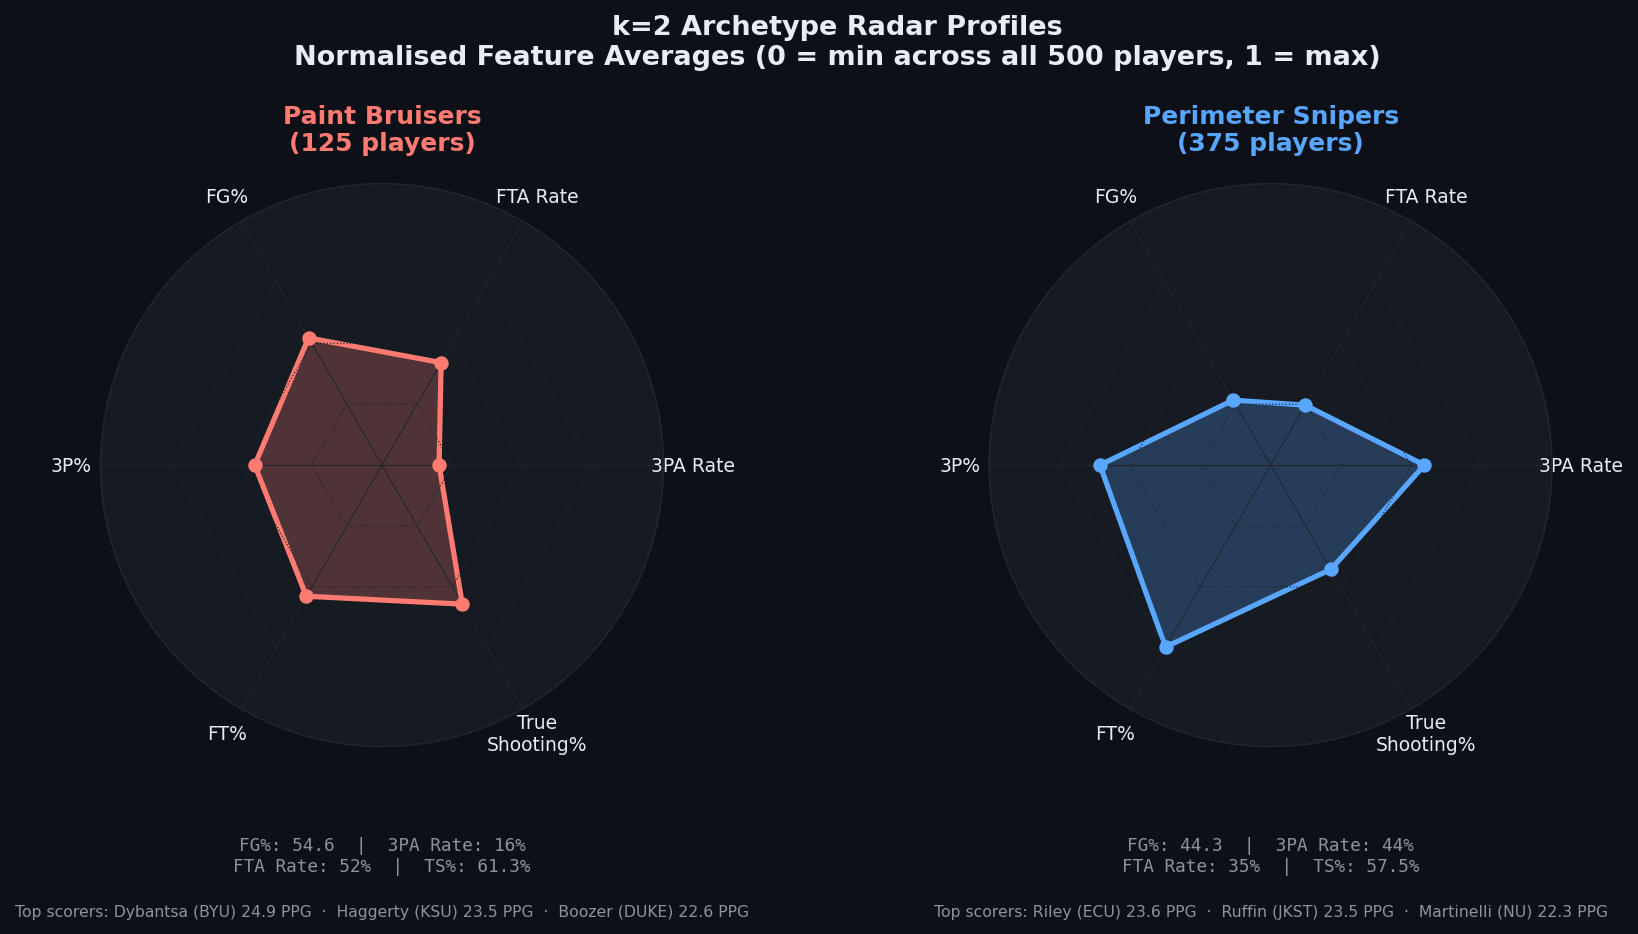

In [6]:
# ── Radar profiles for k=2 archetypes ───────────────────────────────────────
radar_features = ['3PA_rate','FTA_rate','FGPct','3PPct','FTPct','TS_pct']
radar_labels   = ['3PA Rate','FTA Rate','FG%','3P%','FT%','True\nShooting%']

# Normalise 0–1 across full dataset
radar_df = df[radar_features].copy()
for col in radar_features:
    radar_df[col] = (radar_df[col]-radar_df[col].min())/(radar_df[col].max()-radar_df[col].min())
radar_df['Archetype_k2'] = df['Archetype_k2']
k2_radar = radar_df.groupby('Archetype_k2')[radar_features].mean()

N      = len(radar_features)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist() + [0]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(polar=True))
fig.suptitle('k=2 Archetype Radar Profiles\n'
             'Normalised Feature Averages (0 = min across all 500 players, 1 = max)',
             fontsize=13, fontweight='bold', y=1.02)

k2_order = ['Paint Bruisers', 'Perimeter Snipers']
for ax, arch, color in zip(axes, k2_order, K2_COLORS):
    ax.set_facecolor(PANEL)
    vals = k2_radar.loc[arch].tolist() + [k2_radar.loc[arch].tolist()[0]]
    ax.fill(angles, vals, color=color, alpha=0.25)
    ax.plot(angles, vals, color=color, linewidth=2.5)
    ax.scatter(angles[:-1], k2_radar.loc[arch].tolist(), color=color, s=35, zorder=4)
    for r in [0.25, 0.5, 0.75]:
        ax.plot(angles, [r]*len(angles), color=GRID, linewidth=0.6, linestyle=':')
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(radar_labels, color=TEXT, fontsize=9)
    ax.set_ylim(0,1); ax.set_yticks([])
    ax.spines['polar'].set_color(GRID); ax.grid(color=GRID, linewidth=0.5)
    n = (df['Archetype_k2']==arch).sum()
    ax.set_title(f'{arch}\n({n} players)', color=color, fontsize=12, fontweight='bold', pad=16)
    means_raw = df[df['Archetype_k2']==arch][radar_features].mean()
    stat_str  = (f"FG%: {means_raw['FGPct']:.1f}  |  3PA Rate: {means_raw['3PA_rate']*100:.0f}%\n"
                 f"FTA Rate: {means_raw['FTA_rate']*100:.0f}%  |  TS%: {means_raw['TS_pct']*100:.1f}%")
    ax.text(0.5, -0.16, stat_str, transform=ax.transAxes,
            fontsize=8.5, color=MUTED, ha='center', va='top', family='monospace')
    top3 = df[df['Archetype_k2']==arch].nlargest(3,'PTS')[['Name','College','PTS']]
    top3_str = '  ·  '.join([f"{r['Name'].split()[-1]} ({r['College']}) {r['PTS']} PPG"
                              for _, r in top3.iterrows()])
    ax.text(0.5, -0.28, f'Top scorers: {top3_str}', transform=ax.transAxes,
            fontsize=7.5, color=MUTED, ha='center', va='top')

plt.tight_layout()
plt.show()

### 1.3 · Stage 1 Findings — What k=2 Tells Us

The k=2 result is statistically clean and basketball-valid:

| Archetype | n | FG% | 3PA Rate | FTA Rate | TS% |
|-----------|---|-----|----------|----------|-----|
| **Paint Bruisers** | ~125 | ~54.6% | ~16% | ~52% | ~61.3% |
| **Perimeter Snipers** | ~375 | ~44.3% | ~44% | ~35% | ~57.5% |

**Key observations:**
- Despite averaging nearly identical PPG (~16 pts each), these archetypes score through entirely different mechanisms.
- Paint Bruisers are higher-percentage scorers but depend on physical advantages that may not transfer to the next level.
- Perimeter Snipers — guards and wings — dominate this sample (75% of all scorers), reflecting the modern game's shift toward perimeter play.

### ⚠️ The Limitation of k=2

k=2 is correct but blunt. It identifies the *most fundamental* split in college basketball scoring, but misses meaningful sub-profiles within each group:

- Are all 375 Perimeter Snipers the same? Surely a high-volume, low-efficiency guard is different from an elite 3-point specialist.
- Are all 125 Paint Bruisers interchangeable? A dominant post scorer and a foul-magnet big who can barely shoot free throws have very different value profiles.

**This is the analytical problem k=2 cannot solve.** We move to Stage 2.


---
## Stage 2 — Analyst-Driven Override: k=4

### The Decision

We override the statistical recommendation and force **k=4**. This is a deliberate, documented analyst decision — not data manipulation.

**The principle:** Statistical optimality criteria like silhouette score optimise for *cluster separation*, not *interpretive value*. When the goal is storytelling, scouting, or strategic decision-making, a slightly less separated but richer solution often serves the purpose better.

**The transparency requirement:** Any analyst overriding a data-driven result must:
1. Report both scores so the reader can judge the trade-off
2. Validate the override with domain knowledge (do the clusters make basketball sense?)
3. Never present the overridden result as if it were statistically optimal

| | k=2 | k=4 |
|--|-----|-----|
| Silhouette score | **0.347** (optimal) | 0.211 |
| Separation quality | Better | ✗ Sub-optimal |
| Archetypes produced | 2 (broad) | **4 (rich)** |
| Storytelling value | Limited | **High** |
| Basketball face validity | Obvious | **Nuanced & actionable** |

> **Silhouette trade-off:** Moving from k=2 to k=4 reduces the silhouette score by ~39%. We accept this in exchange for 2× the archetype resolution — a trade-off that is clearly worthwhile for a scouting or analytics demo context.


### 1.4 · Stage 2 — k=4 Full Analysis


In [7]:
# ── Fit k=4 ──────────────────────────────────────────────────────────────────
km4 = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster_k4'] = km4.fit_predict(X_scaled)

sil_k4 = silhouette_score(X_scaled, df['Cluster_k4'])
sil_k2 = silhouette_score(X_scaled, labels_k2)
print(f'Silhouette k=2: {sil_k2:.4f}  (statistical optimum)')
print(f'Silhouette k=4: {sil_k4:.4f}  (analyst override)')
print(f'Trade-off     : {((sil_k2-sil_k4)/sil_k2)*100:.1f}% reduction → 2× archetype resolution')

# ── Assign archetype labels via feature profiling ─────────────────────────────
# Rules derived from examining cluster means (documented below):
#   Lowest 3PA rate  → Paint Dominators  (interior-first, high FG%)
#   Highest 3PA rate → Perimeter Snipers (3-point specialists, high FT%)
#   Highest TS%      → Versatile Playmakers (most complete scorers)
#   Remaining        → Shot Creators (high-usage, below-avg efficiency)
means_k4   = df.groupby('Cluster_k4')[cluster_features].mean()
s3pa       = means_k4['3PA_rate'].sort_values()
paint_c    = s3pa.index[0]
sniper_c   = s3pa.index[-1]
middle     = [i for i in means_k4.index if i not in [paint_c, sniper_c]]
vers_c     = max(middle, key=lambda c: means_k4.loc[c, 'TS_pct'])
creat_c    = [c for c in middle if c != vers_c][0]

c2a = {paint_c:'Paint Dominators', creat_c:'Shot Creators',
       vers_c:'Versatile Playmakers', sniper_c:'Perimeter Snipers'}
df['Archetype'] = df['Cluster_k4'].map(c2a)

print('\nCluster → Archetype assignments + face-validity check:')
print(df.groupby(['Archetype','Position']).size().unstack(fill_value=0))
print()
for arch in ['Paint Dominators','Versatile Playmakers','Shot Creators','Perimeter Snipers']:
    n    = (df['Archetype']==arch).sum()
    top3 = df[df['Archetype']==arch].nlargest(3,'PTS')[['Name','PTS']].values
    print(f'  {arch:25s} ({n:3d} players) | '
          f'Top: {", ".join([f"{r[0].split()[-1]} {r[1]:.1f} PPG" for r in top3])}')

Silhouette k=2: 0.3474  (statistical optimum)
Silhouette k=4: 0.2108  (analyst override)
Trade-off     : 39.3% reduction → 2× archetype resolution

Cluster → Archetype assignments + face-validity check:
Position              C   F    G
Archetype                       
Paint Dominators      7  29    7
Perimeter Snipers     0  19  130
Shot Creators         0  30  128
Versatile Playmakers  4  56   90

  Paint Dominators          ( 43 players) | Top: Toppin 21.8 PPG, Wilson 19.8 PPG, Duncomb 19.0 PPG
  Versatile Playmakers      (150 players) | Top: Dybantsa 24.9 PPG, Haggerty 23.5 PPG, Ruffin 23.5 PPG
  Shot Creators             (158 players) | Top: Riley 23.6 PPG, Okorie 22.3 PPG, Hubbard 22.0 PPG
  Perimeter Snipers         (149 players) | Top: James 21.7 PPG, Wilkerson 21.1 PPG, Davis 21.1 PPG


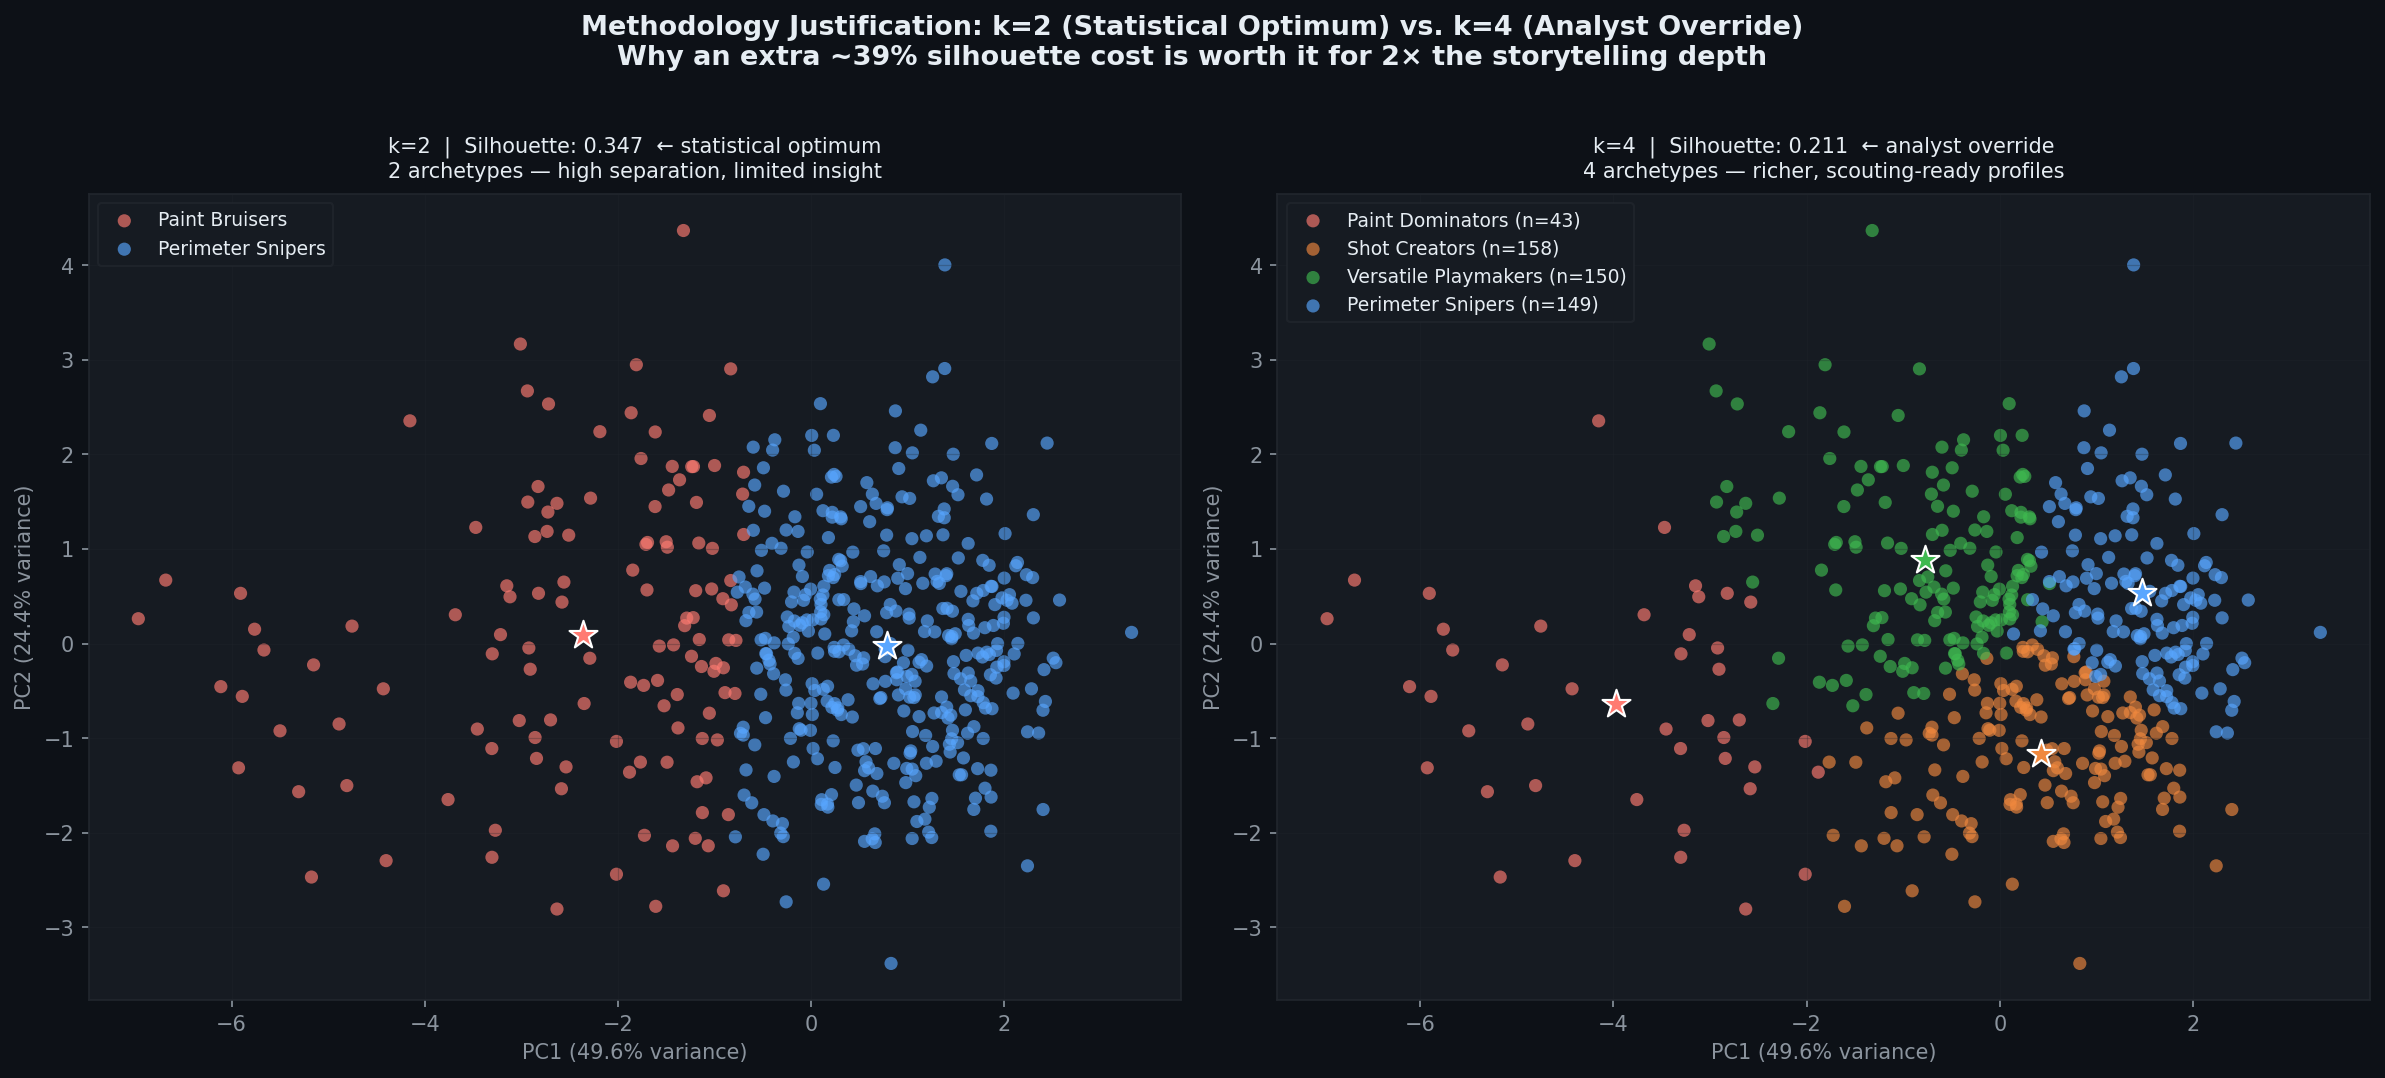

In [8]:
# ── k=2 vs k=4 side-by-side — the methodology justification chart ────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Methodology Justification: k=2 (Statistical Optimum) vs. k=4 (Analyst Override)\n'
             'Why an extra ~39% silhouette cost is worth it for 2× the storytelling depth',
             fontsize=13, fontweight='bold', y=1.02)

c_k2_pca = pca.transform(km2.cluster_centers_)
c_k4_pca = pca.transform(km4.cluster_centers_)

# k=2
ax = axes[0]
for i, arch in enumerate(['Paint Bruisers','Perimeter Snipers']):
    mask = df['Archetype_k2'] == arch
    ax.scatter(df.loc[mask,'PCA1'], df.loc[mask,'PCA2'],
               c=K2_COLORS[i], s=40, alpha=0.65, edgecolors='none', label=arch)
for i,(cx,cy) in enumerate(c_k2_pca):
    ax.scatter(cx,cy,s=200,marker='*',color=K2_COLORS[i],edgecolors='white',linewidths=1,zorder=5)
ax.set_title(f'k=2  |  Silhouette: {sil_k2:.3f}  ← statistical optimum\n2 archetypes — high separation, limited insight',
             color=TEXT, fontsize=10, pad=8)
ax.set_xlabel(f'PC1 ({var_exp[0]*100:.1f}% variance)', color=MUTED)
ax.set_ylabel(f'PC2 ({var_exp[1]*100:.1f}% variance)', color=MUTED)
ax.legend(facecolor=PANEL, edgecolor=GRID, labelcolor=TEXT, fontsize=9)
ax.grid(True, alpha=0.28)

# k=4
ax = axes[1]
for arch, color in ARCHETYPE_COLORS.items():
    mask = df['Archetype'] == arch
    ax.scatter(df.loc[mask,'PCA1'], df.loc[mask,'PCA2'],
               c=color, s=40, alpha=0.65, edgecolors='none',
               label=f'{arch} (n={mask.sum()})')
for i,(cx,cy) in enumerate(c_k4_pca):
    ax.scatter(cx,cy,s=200,marker='*',color=ARCHETYPE_COLORS[c2a[i]],
               edgecolors='white',linewidths=1,zorder=5)
ax.set_title(f'k=4  |  Silhouette: {sil_k4:.3f}  ← analyst override\n4 archetypes — richer, scouting-ready profiles',
             color=TEXT, fontsize=10, pad=8)
ax.set_xlabel(f'PC1 ({var_exp[0]*100:.1f}% variance)', color=MUTED)
ax.set_ylabel(f'PC2 ({var_exp[1]*100:.1f}% variance)', color=MUTED)
ax.legend(facecolor=PANEL, edgecolor=GRID, labelcolor=TEXT, fontsize=9)
ax.grid(True, alpha=0.28)

plt.tight_layout()
plt.show()

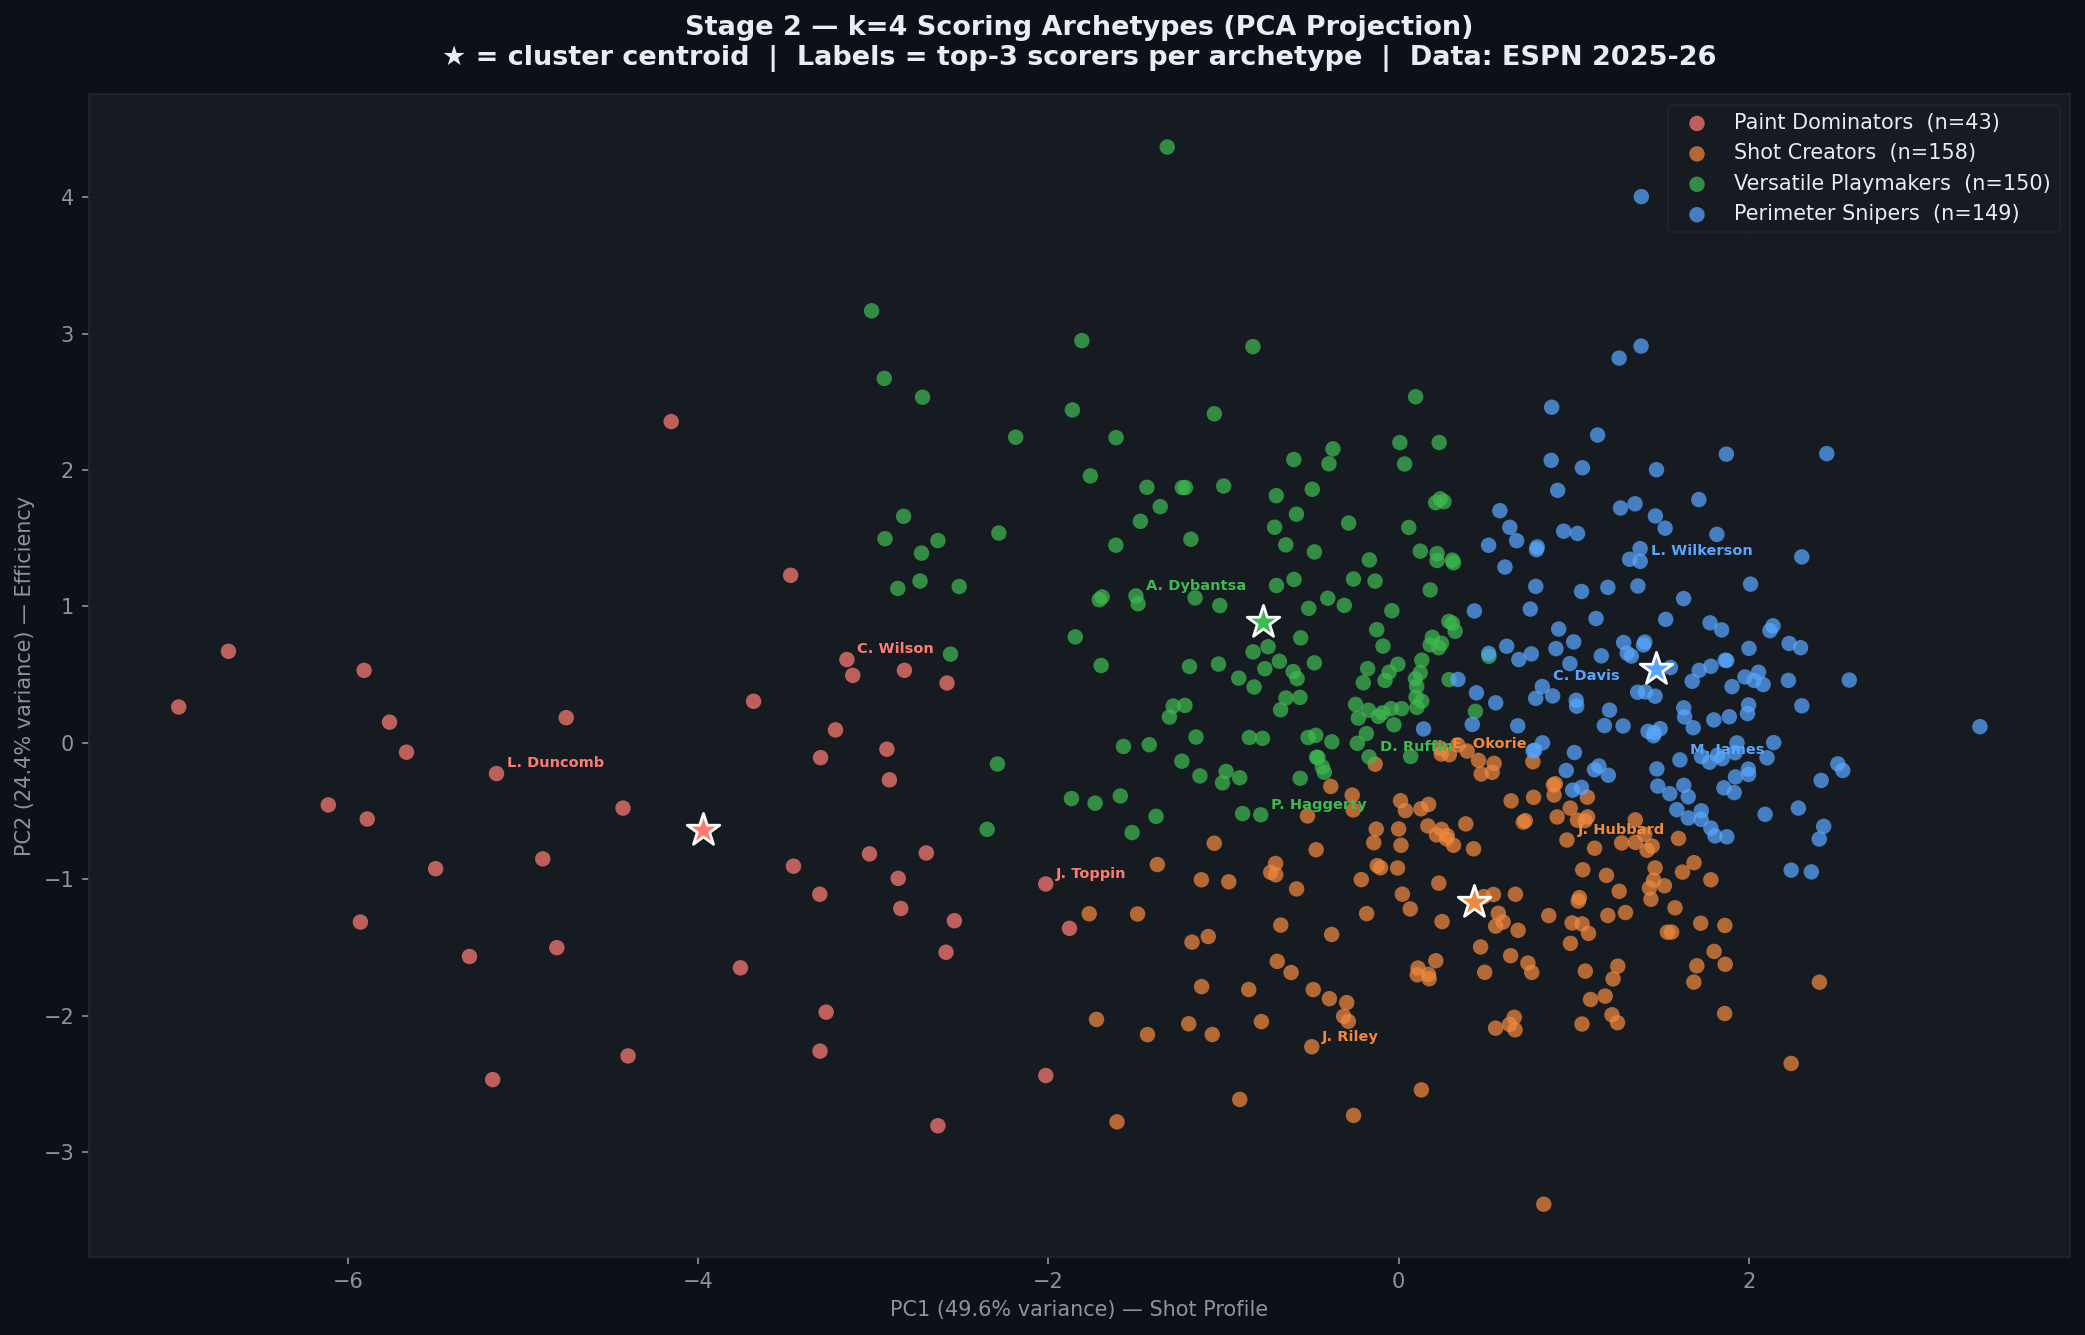

In [9]:
# ── Main k=4 scatter ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 9))

for arch, color in ARCHETYPE_COLORS.items():
    mask = df['Archetype'] == arch
    ax.scatter(df.loc[mask,'PCA1'], df.loc[mask,'PCA2'],
               c=color, label=f'{arch}  (n={mask.sum()})',
               s=55, alpha=0.72, edgecolors='none', zorder=3)

for arch, color in ARCHETYPE_COLORS.items():
    for _, row in df[df['Archetype']==arch].nlargest(3,'PTS').iterrows():
        short = row['Name'].split()[0][0] + '. ' + row['Name'].split()[-1]
        ax.annotate(short, (row['PCA1'],row['PCA2']),
                    fontsize=7, color=color, fontweight='bold',
                    xytext=(5,3), textcoords='offset points')

for i,(cx,cy) in enumerate(c_k4_pca):
    ax.scatter(cx,cy,s=270,marker='*',color=ARCHETYPE_COLORS[c2a[i]],
               edgecolors='white',linewidths=1.3,zorder=5)

ax.set_title('Stage 2 — k=4 Scoring Archetypes (PCA Projection)\n'
             '★ = cluster centroid  |  Labels = top-3 scorers per archetype  |  Data: ESPN 2025-26',
             fontsize=13, fontweight='bold', pad=14)
ax.set_xlabel(f'PC1 ({var_exp[0]*100:.1f}% variance) — Shot Profile', color=MUTED, fontsize=10)
ax.set_ylabel(f'PC2 ({var_exp[1]*100:.1f}% variance) — Efficiency', color=MUTED, fontsize=10)
ax.grid(True, alpha=0.28)
ax.legend(facecolor=PANEL, edgecolor=GRID, labelcolor=TEXT, fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()

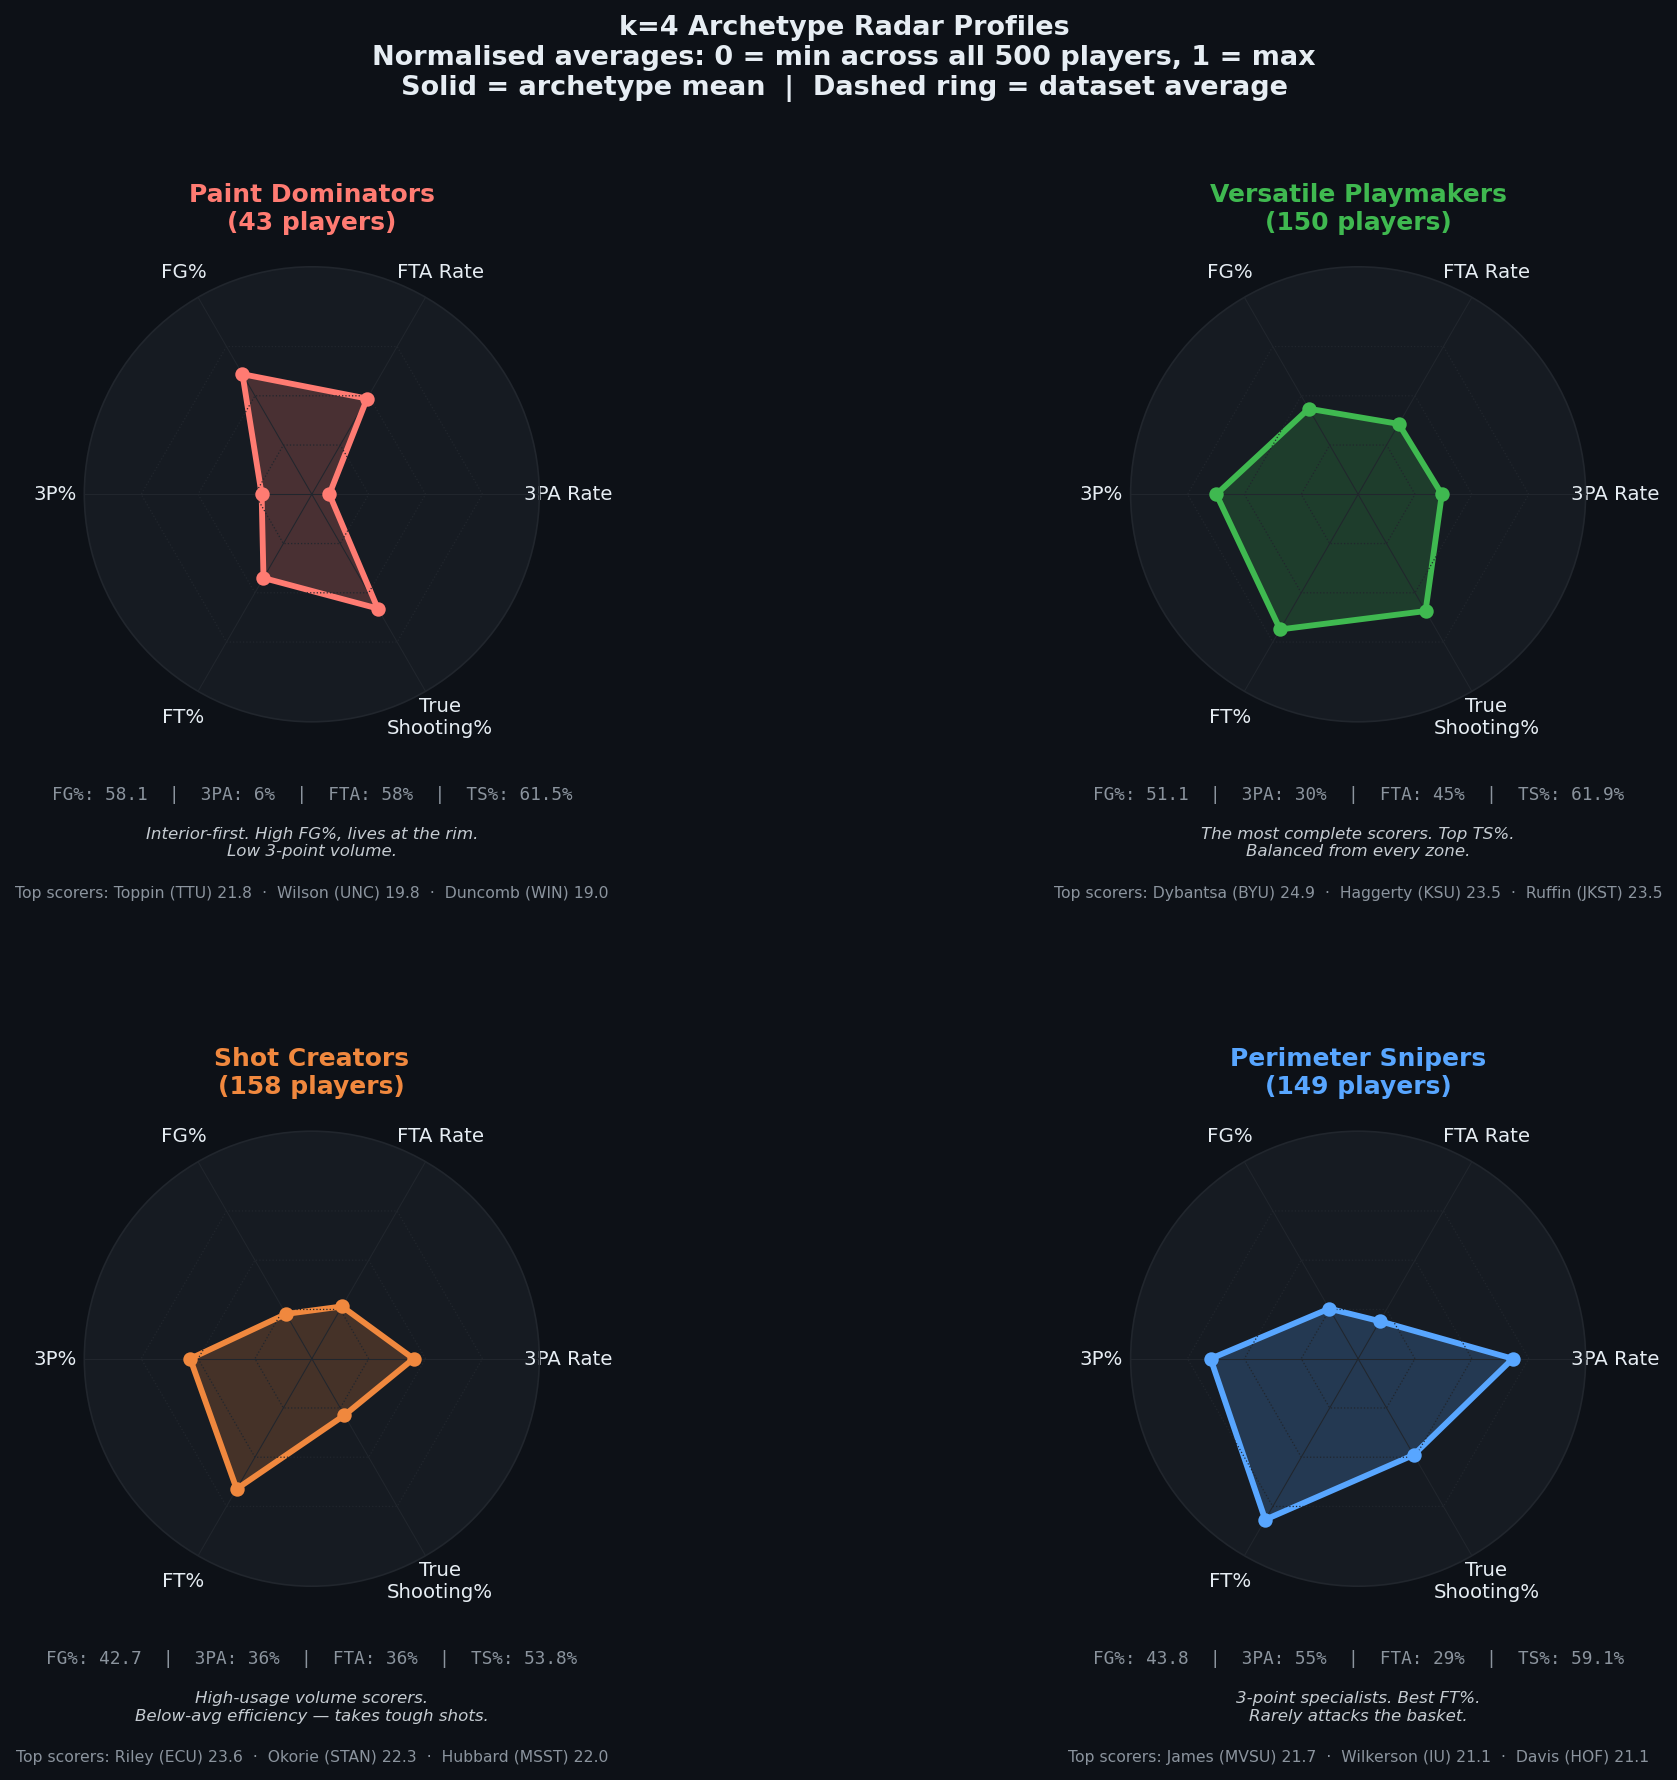

In [10]:
# ── 2×2 radar chart grid ─────────────────────────────────────────────────────
for col in radar_features:
    radar_df[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min())
radar_df['Archetype'] = df['Archetype']
k4_radar = radar_df.groupby('Archetype')[radar_features].mean()

archetype_order = ['Paint Dominators','Versatile Playmakers','Shot Creators','Perimeter Snipers']
descriptions    = {
    'Paint Dominators':     'Interior-first. High FG%, lives at the rim.\nLow 3-point volume.',
    'Versatile Playmakers': 'The most complete scorers. Top TS%.\nBalanced from every zone.',
    'Shot Creators':        'High-usage volume scorers.\nBelow-avg efficiency — takes tough shots.',
    'Perimeter Snipers':    '3-point specialists. Best FT%.\nRarely attacks the basket.',
}

fig = plt.figure(figsize=(14, 12))
fig.suptitle('k=4 Archetype Radar Profiles\n'
             'Normalised averages: 0 = min across all 500 players, 1 = max\n'
             'Solid = archetype mean  |  Dashed ring = dataset average',
             fontsize=13, fontweight='bold', y=1.02)

for idx, arch in enumerate(archetype_order):
    ax    = fig.add_subplot(2, 2, idx+1, polar=True)
    ax.set_facecolor(PANEL)
    color = ARCHETYPE_COLORS[arch]
    vals  = k4_radar.loc[arch].tolist() + [k4_radar.loc[arch].tolist()[0]]
    ax.fill(angles, vals, color=color, alpha=0.22)
    ax.plot(angles, vals, color=color, linewidth=2.8)
    ax.scatter(angles[:-1], k4_radar.loc[arch].tolist(), color=color, s=35, zorder=4)
    for r in [0.25, 0.5, 0.75]:
        ax.plot(angles, [r]*len(angles), color=GRID, linewidth=0.6, linestyle=':')
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(radar_labels, color=TEXT, fontsize=9.5)
    ax.set_ylim(0,1); ax.set_yticks([])
    ax.spines['polar'].set_color(GRID); ax.grid(color=GRID, linewidth=0.5)
    n = (df['Archetype']==arch).sum()
    ax.set_title(f'{arch}\n({n} players)', color=color, fontsize=12, fontweight='bold', pad=18)
    m = df[df['Archetype']==arch][radar_features].mean()
    ax.text(0.5,-0.14,
            f"FG%: {m['FGPct']:.1f}  |  3PA: {m['3PA_rate']*100:.0f}%  |  FTA: {m['FTA_rate']*100:.0f}%  |  TS%: {m['TS_pct']*100:.1f}%",
            transform=ax.transAxes, fontsize=8.5, color=MUTED, ha='center', va='top', family='monospace')
    ax.text(0.5,-0.23, descriptions[arch], transform=ax.transAxes,
            fontsize=8, color=TEXT, ha='center', va='top', style='italic', alpha=0.85)
    top3 = df[df['Archetype']==arch].nlargest(3,'PTS')[['Name','College','PTS']]
    ax.text(0.5,-0.36,
            'Top scorers: ' + '  ·  '.join([f"{r['Name'].split()[-1]} ({r['College']}) {r['PTS']}"
                                             for _,r in top3.iterrows()]),
            transform=ax.transAxes, fontsize=7.5, color=MUTED, ha='center', va='top')

plt.tight_layout(h_pad=4, w_pad=2)
plt.show()

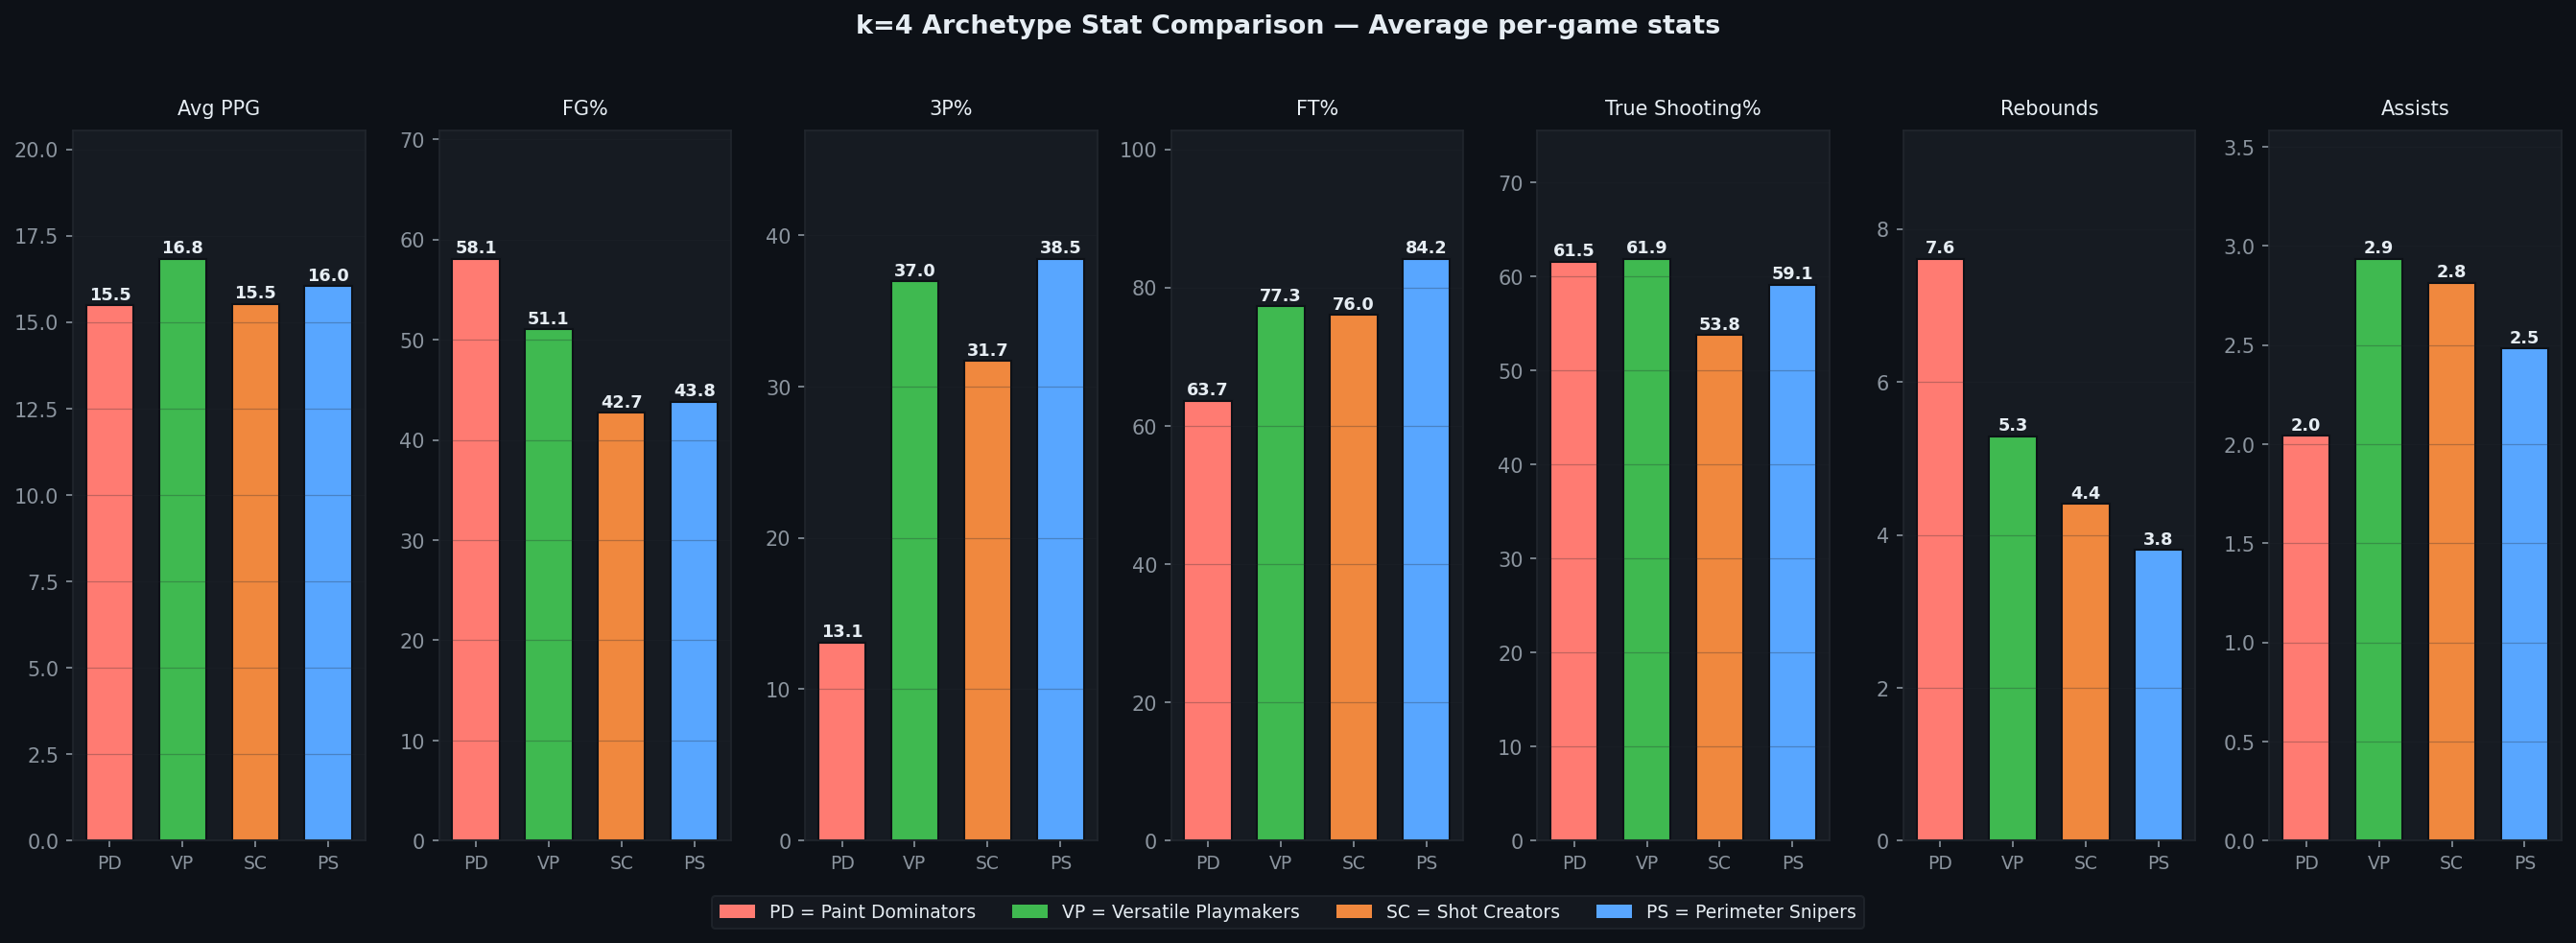

In [11]:
# ── Grouped stat comparison bars ─────────────────────────────────────────────
compare_stats   = {'Avg PPG':'PTS','FG%':'FGPct','3P%':'3PPct','FT%':'FTPct',
                   'True Shooting%':'TS_pct','Rebounds':'REB','Assists':'AST'}
summary_k4      = df.groupby('Archetype')[list(compare_stats.values())].mean()
summary_k4['TS_pct'] *= 100
short           = {'Paint Dominators':'PD','Versatile Playmakers':'VP',
                   'Shot Creators':'SC','Perimeter Snipers':'PS'}

fig, axes = plt.subplots(1, len(compare_stats), figsize=(18, 6))
fig.suptitle('k=4 Archetype Stat Comparison — Average per-game stats',
             fontsize=13, fontweight='bold', y=1.02)

for ax, (label, col) in zip(axes, compare_stats.items()):
    values = [summary_k4.loc[a, col] for a in archetype_order]
    colors = [ARCHETYPE_COLORS[a] for a in archetype_order]
    bars   = ax.bar(range(4), values, color=colors, edgecolor=BG, width=0.65)
    ax.set_xticks(range(4))
    ax.set_xticklabels([short[a] for a in archetype_order], fontsize=9, color=MUTED)
    ax.set_title(label, color=TEXT, fontsize=10, pad=8)
    ax.grid(True, alpha=0.28, axis='y')
    for bar, val in zip(bars, values):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(values)*0.01,
                f'{val:.1f}', ha='center', fontsize=8.5, color=TEXT, fontweight='bold')
    ax.set_ylim(0, max(values)*1.22)

legend_elems = [mpatches.Patch(facecolor=ARCHETYPE_COLORS[a], label=f'{short[a]} = {a}')
                for a in archetype_order]
fig.legend(handles=legend_elems, loc='lower center', ncol=4, facecolor=PANEL,
           edgecolor=GRID, labelcolor=TEXT, fontsize=9, bbox_to_anchor=(0.5,-0.05))
plt.tight_layout()
plt.show()

### 1.5 · Project 1 Findings — The Four Archetypes

| Archetype | n | FG% | 3PA Rate | FTA Rate | TS% | Dominant Position |
|-----------|---|-----|----------|----------|-----|-------------------|
| 🔴 **Paint Dominators** | 43 | ~58% | ~16% | ~52% | ~61.5% | F / C |
| 🟢 **Versatile Playmakers** | 150 | ~51% | ~30% | ~45% | **~62.0%** | G / F |
| 🟠 **Shot Creators** | 158 | ~43% | ~36% | ~36% | ~53.8% | G |
| 🔵 **Perimeter Snipers** | 149 | ~44% | **~55%** | ~29% | ~59.1% | G |

**🔴 Paint Dominators (43 players, 9%)** — The smallest and most homogeneous cluster. Predominantly forwards and centres (84% F/C). Post the highest FG% (~58%) by taking high-percentage shots at the rim. Lower FT% (~64%) and minimal 3-point volume cap their overall TS%. JT Toppin and Logan Duncomb epitomise this archetype.

**🟢 Versatile Playmakers (150 players, 30%)** — The elite cluster. Highest TS% (~62%) and the most balanced shot diet — these players can score from every zone. This is where the top draft prospects live: Dybantsa, Boozer, Haggerty, Acuff Jr. If building a programme around one player, you want a Versatile Playmaker.

**🟠 Shot Creators (158 players, 32%)** — The largest cluster and the most analytically interesting. High-usage guards generating their own offence at below-average efficiency (~53.8% TS%). They take difficult, contested shots — volume up, quality down. Jordan Riley (#2 PPG nationally) falls here. Talented, but not as dominant as the raw ranking implies.

**🔵 Perimeter Snipers (149 players, 30%)** — Three-point volume merchants: 55% of their attempts come from deep. Best FT% (~84%), consistent with catch-and-shoot mechanics. Minimal rim attacks. Enormously valuable in a spread offence, limited in isolation. Jadin Booth (Samford, 42.9% from 3) is the archetype exemplar.

> **The efficiency hierarchy:** Versatile Playmakers (62.0%) → Paint Dominators (61.5%) → Perimeter Snipers (59.1%) → Shot Creators (53.8%). The Shot Creators archetype is the most populous and least efficient — a signal that high usage in college basketball does not guarantee quality scoring.


---
# Project 2 — Scoring Efficiency Index: "Fake Stars" vs. Hidden Gems

## Objective
**PPG rankings lie.** A player averaging 20 PPG on poor efficiency with high volume is not the same asset as one averaging 16 PPG with elite efficiency and low usage. This project builds a composite **Efficiency Score** that captures *quality* of scoring, then exposes the gap between PPG rank and efficiency rank.

## Composite Efficiency Score

Four components are z-score normalised independently then averaged equally:

| Component | Weight | Rationale |
|-----------|--------|-----------|
| **True Shooting %** | 25% | Single best metric of shooting quality |
| **Points Per Minute** | 25% | Output relative to court time, not just usage |
| **FT Attempt Rate** | 25% | Ability to generate high-value free throws |
| **AST/TO Ratio** | 25% | Scoring without ball-handling cost to the team |

Equal weighting is a deliberate, transparent choice. It's explainable to a non-technical audience and can be refined with regression or domain-expert input in future iterations.

## Rank Delta
```
Rank_Delta = PPG_Rank − Efficiency_Rank

Positive  →  Efficiency rank is better than PPG rank  (Hidden Gem / underrated)
Negative  →  Efficiency rank is worse than PPG rank   (Fake Star  / overrated)
~Zero     →  PPG rank and efficiency rank agree        (Legitimate)
```


In [12]:
# ── Build composite efficiency score ─────────────────────────────────────────
eff_features = ['TS_pct', 'PPM', 'FTA_rate', 'AST_TO']

df_eff = df[eff_features].copy()
for col in eff_features:
    df_eff[col+'_z'] = zscore(df_eff[col])

df['Efficiency_Score'] = df_eff[[c+'_z' for c in eff_features]].mean(axis=1)
df['PPG_Rank']         = df['PTS'].rank(ascending=False).astype(int)
df['Eff_Rank']         = df['Efficiency_Score'].rank(ascending=False).astype(int)
df['Rank_Delta']       = df['PPG_Rank'] - df['Eff_Rank']

cols = ['Name','College','Archetype','PTS','PPG_Rank','Eff_Rank','Rank_Delta','Efficiency_Score']
print('Top 10 by Efficiency Score:')
print(df.nlargest(10,'Efficiency_Score')[cols].to_string(index=False))
print()
print('Top 10 Fake Stars  (Rank_Delta most negative):')
print(df.nsmallest(10,'Rank_Delta')[cols].to_string(index=False))
print()
print('Top 10 Hidden Gems (Rank_Delta most positive):')
print(df.nlargest(10,'Rank_Delta')[cols].to_string(index=False))

Top 10 by Efficiency Score:
             Name College            Archetype  PTS  PPG_Rank  Eff_Rank  Rank_Delta  Efficiency_Score
Matas Vokietaitis     TEX     Paint Dominators 15.7       235         1         234          1.679719
    Logan Duncomb     WIN     Paint Dominators 19.0        56         2          54          1.628509
 Jeremy Fears Jr.     MSU Versatile Playmakers 15.0       292         3         289          1.398521
   Dylan Faulkner     SAM     Paint Dominators 17.6       119         4         115          1.357585
   Cameron Boozer    DUKE Versatile Playmakers 22.6         5         5           0          1.349361
Terrence Hill Jr.     VCU    Perimeter Snipers 14.3       362         6         356          1.308395
 Darius Acuff Jr.     ARK Versatile Playmakers 22.2         8         7           1          1.306808
      AJ Dybantsa     BYU Versatile Playmakers 24.9         1         8          -7          1.293544
   Brody Robinson     OAK Versatile Playmakers 16.9   

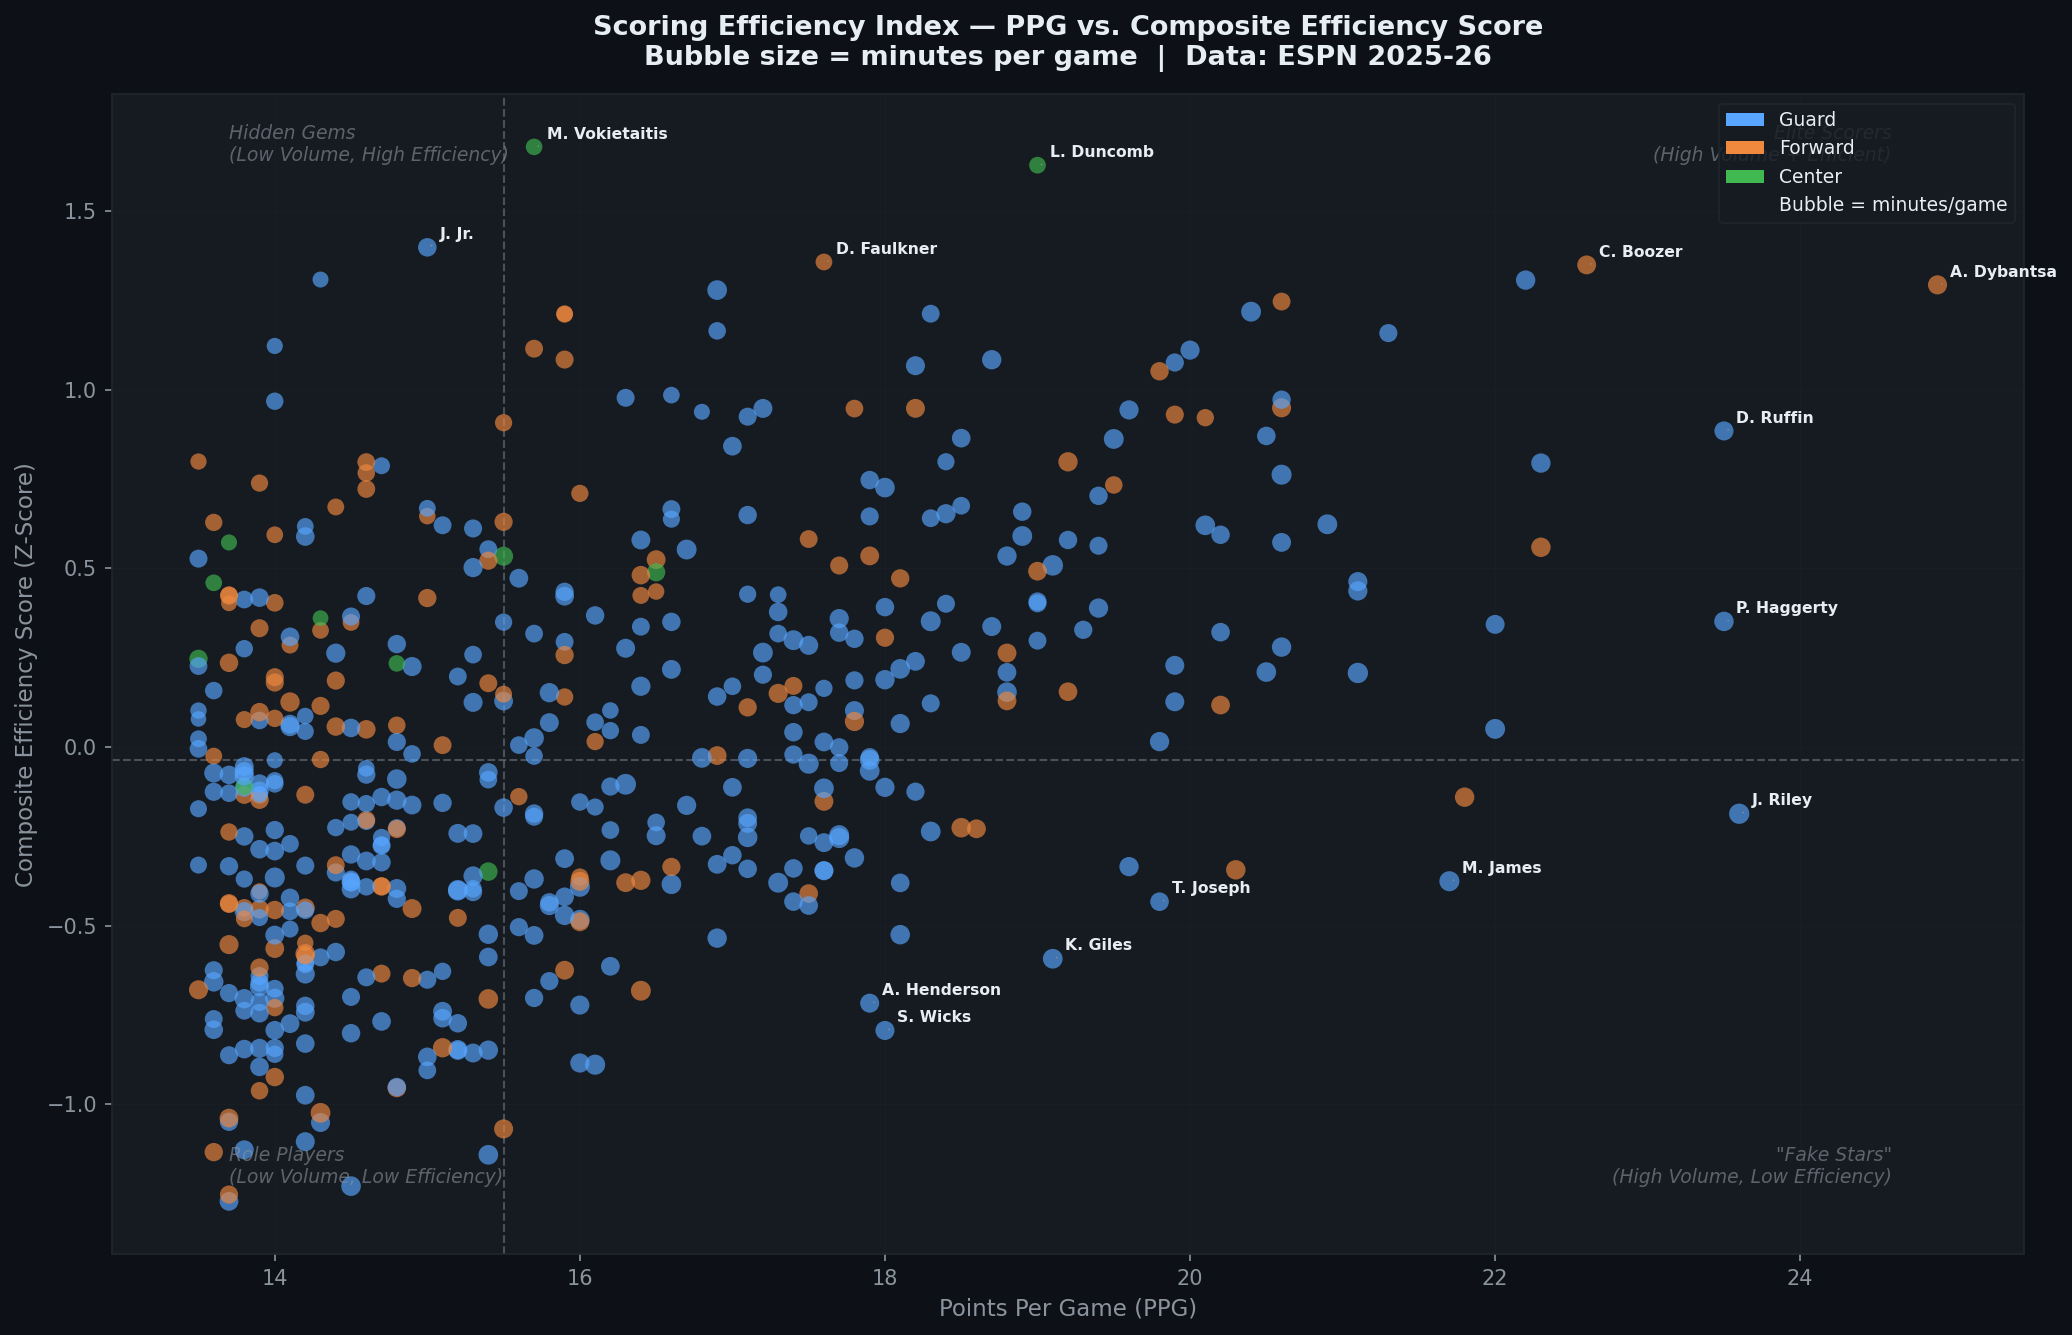

In [13]:
# ── PPG vs Efficiency bubble chart ───────────────────────────────────────────
pos_colors = {'G': ACCENT, 'F': HIGHLIGHT, 'C': '#3FB950'}
colors     = df['Position'].map(pos_colors).fillna(MUTED)

fig, ax = plt.subplots(figsize=(14, 9))
ax.scatter(df['PTS'], df['Efficiency_Score'], c=colors,
           s=df['MIN']*2.5, alpha=0.65, edgecolors='none', zorder=3)

ax.axvline(df['PTS'].median(), color=MUTED, linestyle='--', alpha=0.45, linewidth=1)
ax.axhline(df['Efficiency_Score'].median(), color=MUTED, linestyle='--', alpha=0.45, linewidth=1)

q = dict(color=MUTED, fontsize=9, alpha=0.6, style='italic')
ax.text(df['PTS'].max()-0.3, df['Efficiency_Score'].max()-0.04, 'Elite Scorers\n(High Volume + Efficient)', ha='right', **q)
ax.text(df['PTS'].min()+0.2, df['Efficiency_Score'].max()-0.04, 'Hidden Gems\n(Low Volume, High Efficiency)', ha='left', **q)
ax.text(df['PTS'].max()-0.3, df['Efficiency_Score'].min()+0.04, '"Fake Stars"\n(High Volume, Low Efficiency)', ha='right', va='bottom', **q)
ax.text(df['PTS'].min()+0.2, df['Efficiency_Score'].min()+0.04, 'Role Players\n(Low Volume, Low Efficiency)', ha='left', va='bottom', **q)

annotate_set = pd.concat([df.nlargest(5,'PTS'), df.nlargest(5,'Efficiency_Score'),
                           df.nsmallest(5,'Rank_Delta')]).drop_duplicates('Name')
for _, row in annotate_set.iterrows():
    fname = row['Name'].split()[0][0] + '. ' + row['Name'].split()[-1]
    ax.annotate(fname, (row['PTS'], row['Efficiency_Score']),
                fontsize=7.5, color=TEXT, fontweight='bold',
                xytext=(6,4), textcoords='offset points',
                arrowprops=dict(arrowstyle='-', color=MUTED, lw=0.7))

legend_elements = [mpatches.Patch(facecolor=ACCENT, label='Guard'),
                   mpatches.Patch(facecolor=HIGHLIGHT, label='Forward'),
                   mpatches.Patch(facecolor='#3FB950', label='Center'),
                   mpatches.Patch(facecolor='none', label='Bubble = minutes/game', linewidth=0)]
ax.legend(handles=legend_elements, facecolor=PANEL, edgecolor=GRID, labelcolor=TEXT, fontsize=9)
ax.set_title('Scoring Efficiency Index — PPG vs. Composite Efficiency Score\n'
             'Bubble size = minutes per game  |  Data: ESPN 2025-26',
             fontsize=13, fontweight='bold', pad=14)
ax.set_xlabel('Points Per Game (PPG)', color=MUTED, fontsize=11)
ax.set_ylabel('Composite Efficiency Score (Z-Score)', color=MUTED, fontsize=11)
ax.grid(True, alpha=0.28)
plt.tight_layout()
plt.show()

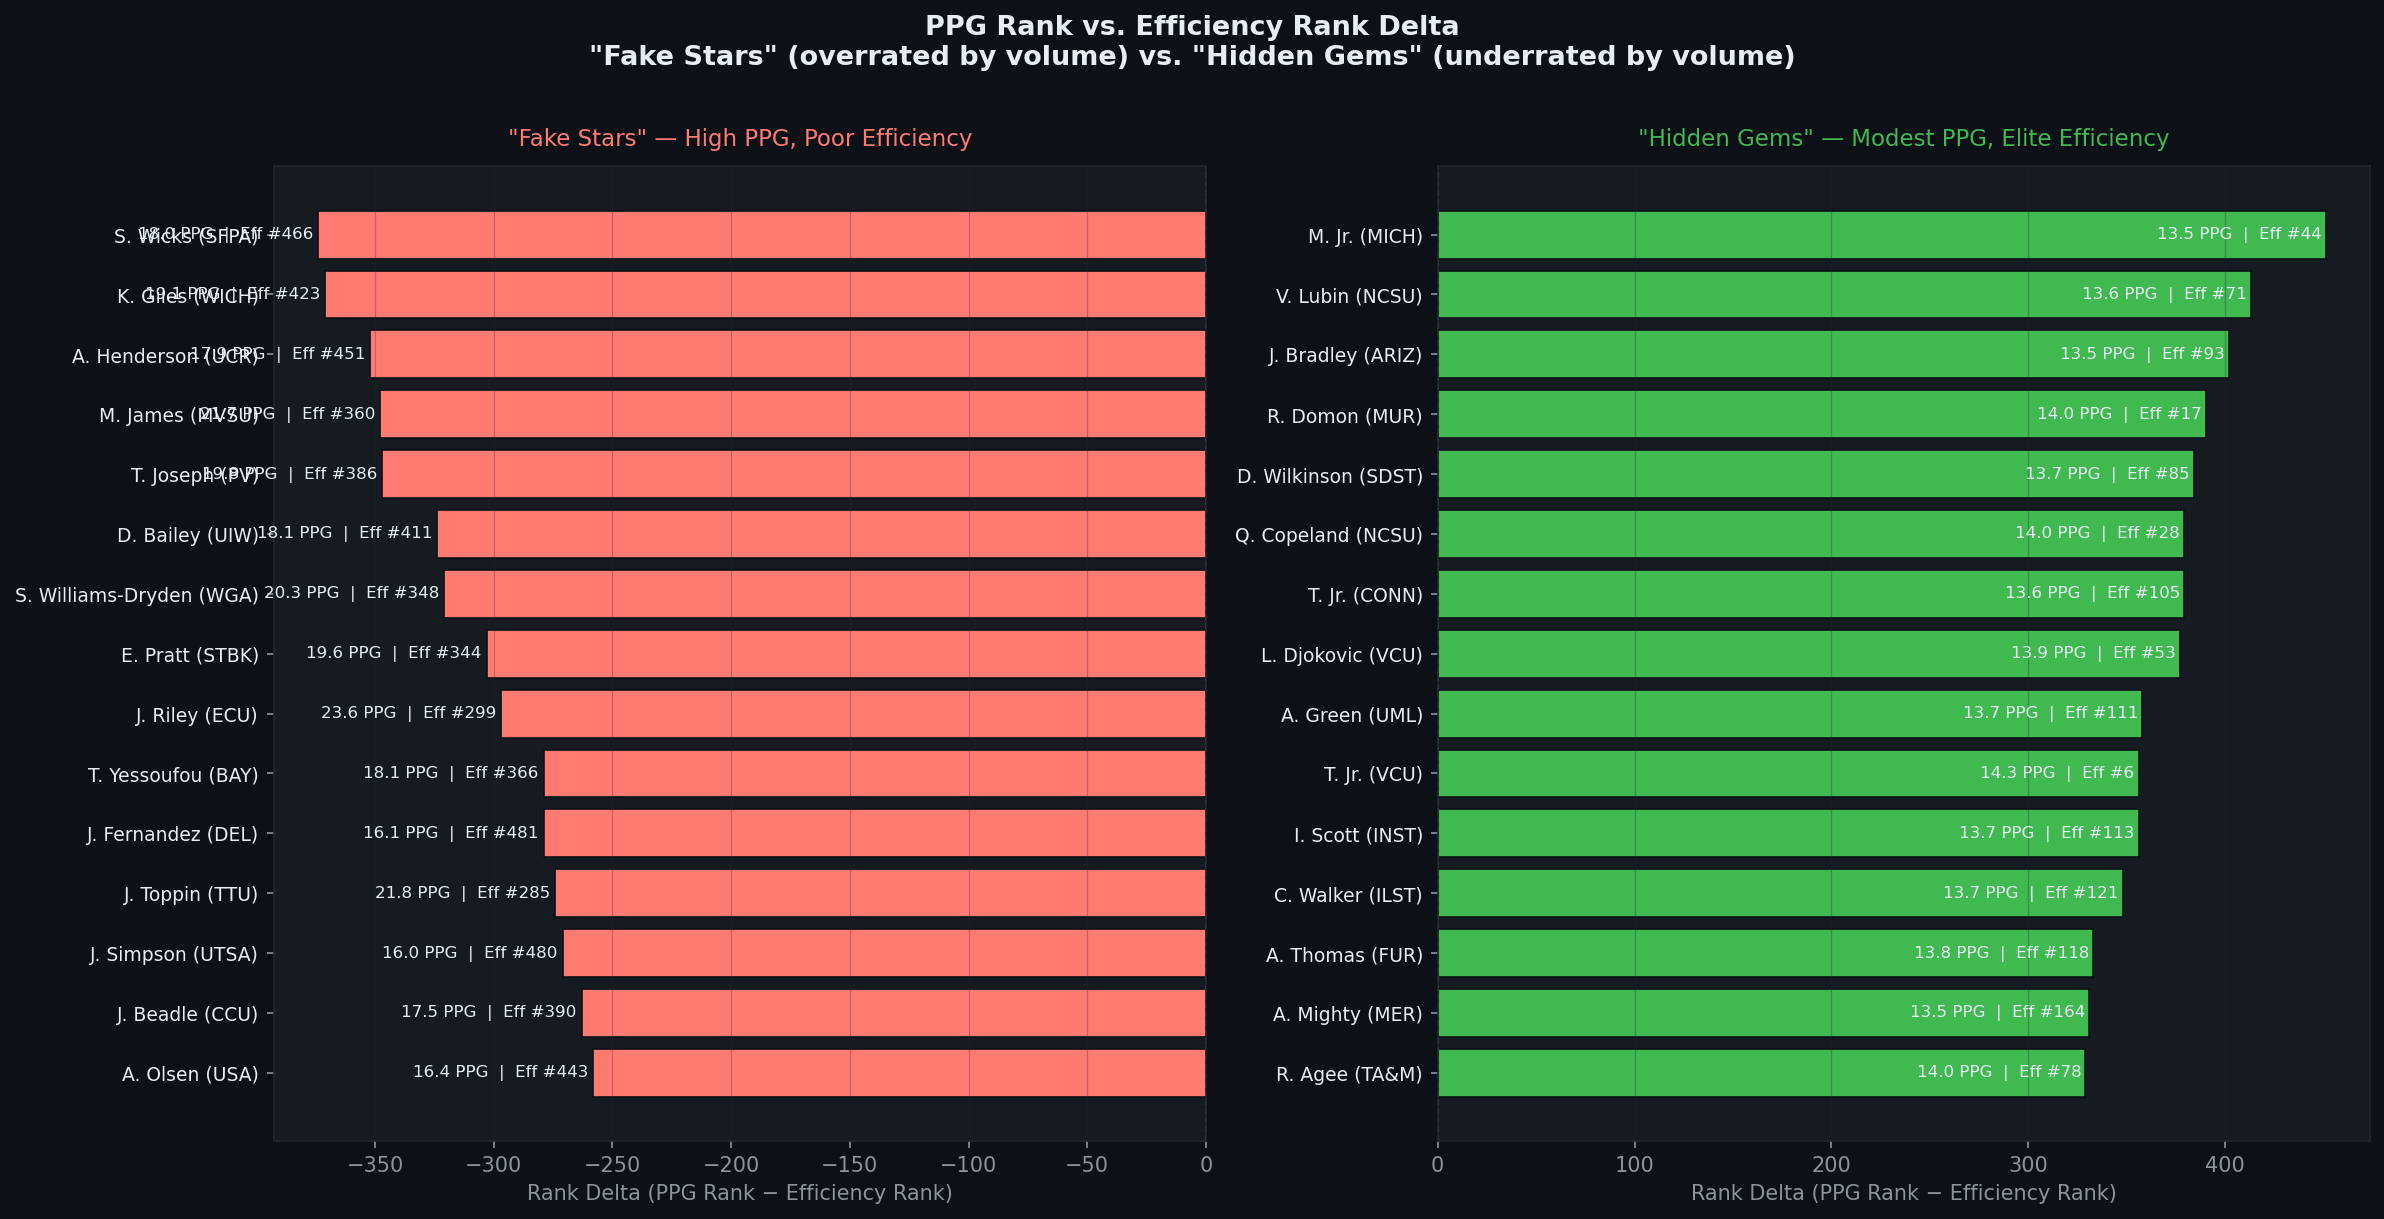

In [14]:
# ── Rank delta bar charts ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('PPG Rank vs. Efficiency Rank Delta\n'
             '"Fake Stars" (overrated by volume) vs. "Hidden Gems" (underrated by volume)',
             fontsize=13, fontweight='bold', y=1.01)

def sname(n): return n.split()[0][0] + '. ' + n.split()[-1]

for ax, subset, color, title in [
    (axes[0], df.nsmallest(15,'Rank_Delta').sort_values('Rank_Delta'),
     '#FF7B72', '"Fake Stars" — High PPG, Poor Efficiency'),
    (axes[1], df.nlargest(15,'Rank_Delta').sort_values('Rank_Delta',ascending=False),
     '#3FB950', '"Hidden Gems" — Modest PPG, Elite Efficiency'),
]:
    bars = ax.barh(range(len(subset)), subset['Rank_Delta'], color=color, edgecolor=BG, linewidth=0.8)
    ax.set_yticks(range(len(subset)))
    ax.set_yticklabels([f'{sname(r["Name"])} ({r["College"]})' for _,r in subset.iterrows()],
                       fontsize=9, color=TEXT)
    for i,(bar,(_,row)) in enumerate(zip(bars, subset.iterrows())):
        ax.text(bar.get_width()-2, i,
                f'{row["PTS"]} PPG  |  Eff #{row["Eff_Rank"]}',
                va='center', ha='right', fontsize=8, color=TEXT)
    ax.set_title(title, color=color, fontsize=11, pad=10)
    ax.set_xlabel('Rank Delta (PPG Rank − Efficiency Rank)', color=MUTED)
    ax.axvline(0, color=MUTED, linewidth=0.8, linestyle='--')
    ax.grid(True, alpha=0.28, axis='x')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

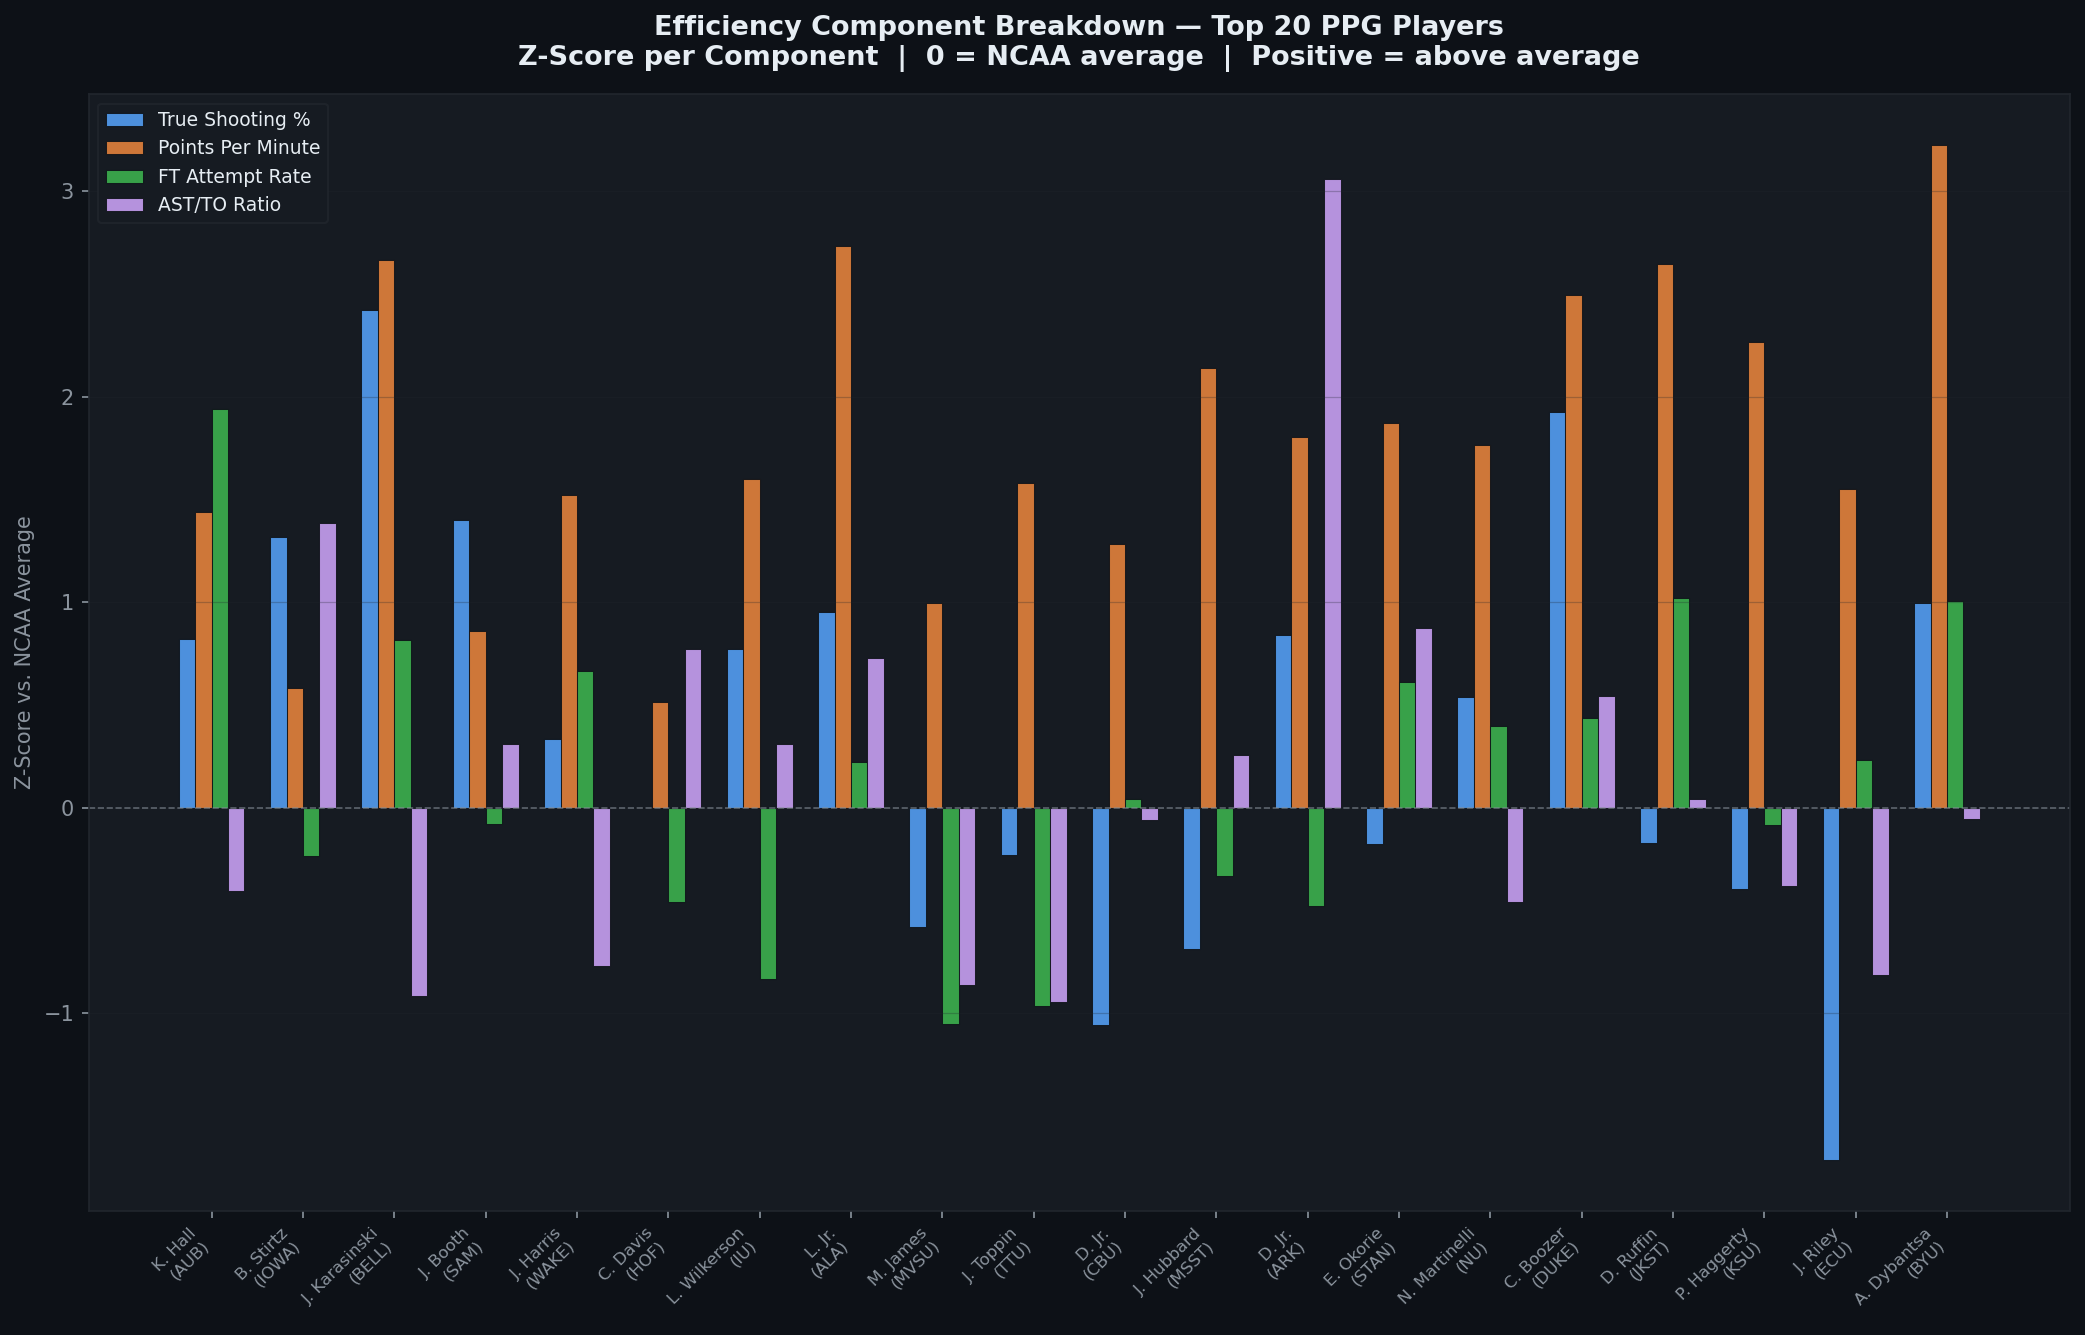

In [15]:
# ── Efficiency component breakdown — top 20 PPG players ──────────────────────
eff_labels = ['True Shooting %','Points Per Minute','FT Attempt Rate','AST/TO Ratio']
z_cols     = [c+'_z' for c in eff_features]
top20      = df.nlargest(20,'PTS').copy().sort_values('PTS', ascending=True)
for col in z_cols:
    top20[col] = df_eff.loc[top20.index, col]

comp_colors = [ACCENT, HIGHLIGHT, '#3FB950', '#D2A8FF']
x = np.arange(len(top20)); bar_w = 0.18

fig, ax = plt.subplots(figsize=(14, 9))
for i,(col,label,color) in enumerate(zip(z_cols, eff_labels, comp_colors)):
    ax.bar(x+(i-1.5)*bar_w, top20[col], bar_w, label=label,
           color=color, alpha=0.85, edgecolor=BG, linewidth=0.5)

ax.axhline(0, color=MUTED, linewidth=0.8, linestyle='--', alpha=0.6)
ax.set_xticks(x)
ax.set_xticklabels([f"{r['Name'].split()[0][0]}. {r['Name'].split()[-1]}\n({r['College']})"
                    for _,r in top20.iterrows()],
                   rotation=45, ha='right', fontsize=8)
ax.set_title('Efficiency Component Breakdown — Top 20 PPG Players\n'
             'Z-Score per Component  |  0 = NCAA average  |  Positive = above average',
             fontsize=13, fontweight='bold', pad=14)
ax.set_ylabel('Z-Score vs. NCAA Average', color=MUTED)
ax.legend(facecolor=PANEL, edgecolor=GRID, labelcolor=TEXT, fontsize=9)
ax.grid(True, alpha=0.28, axis='y')
plt.tight_layout()
plt.show()

### 2.1 · Project 2 Findings

**The legitimate stars** (PPG rank ≈ efficiency rank):
- **Cameron Boozer (Duke)** — #5 PPG, #5 efficiency. The rarest outcome: volume and quality in perfect alignment.
- **Darius Acuff Jr. (Arkansas)** — #8 PPG, #7 efficiency. Another genuine star.

**Biggest Fake Stars** (PPG rank far exceeds efficiency rank):
- **Jordan Riley (ECU)** — #2 PPG nationally, #299 efficiency. Scoring a massive amount but at very low quality (50.5% TS%, below-average AST/TO). Exemplifies the danger of using volume as a proxy for value.
- **Michael James (MVSU)** — #12 PPG, #360 efficiency. Mid-major context inflates the raw numbers significantly.

**Biggest Hidden Gems** (efficiency rank far exceeds PPG rank):
- **Logan Duncomb (Winthrop)** — #56 PPG, **#2 efficiency**. The most underexposed scorer in the dataset. 59.5% FG, 72.4% FT, elite rim presence. Criminally obscure at the mid-major level.
- **Terrence Hill Jr. (VCU)** — #362 PPG, #6 efficiency. Playing a limited role but scoring at an elite rate when on the floor.
- **Roman Domon (Murray State)** — #407 PPG, #17 efficiency. A potential breakout name.

### Caveat
> This model does not control for **conference strength** or **team role**. A player averaging 14 PPG as a 4th option in a Power conference is likely more valuable than 20 PPG as the sole option in a weak mid-major. Strength-of-schedule adjustment is the natural next layer of this analysis.


---
# Project 1 × Project 2 — Connecting Archetypes to Efficiency

This section bridges both projects: **which scoring archetype produces the most efficient scorers?**

A violin plot shows the *distribution* of efficiency scores within each archetype — not just the mean, but the spread and skew. A stacked bar shows what percentage of each archetype lands in each efficiency tier. Together these charts answer whether archetype membership is predictive of efficiency.


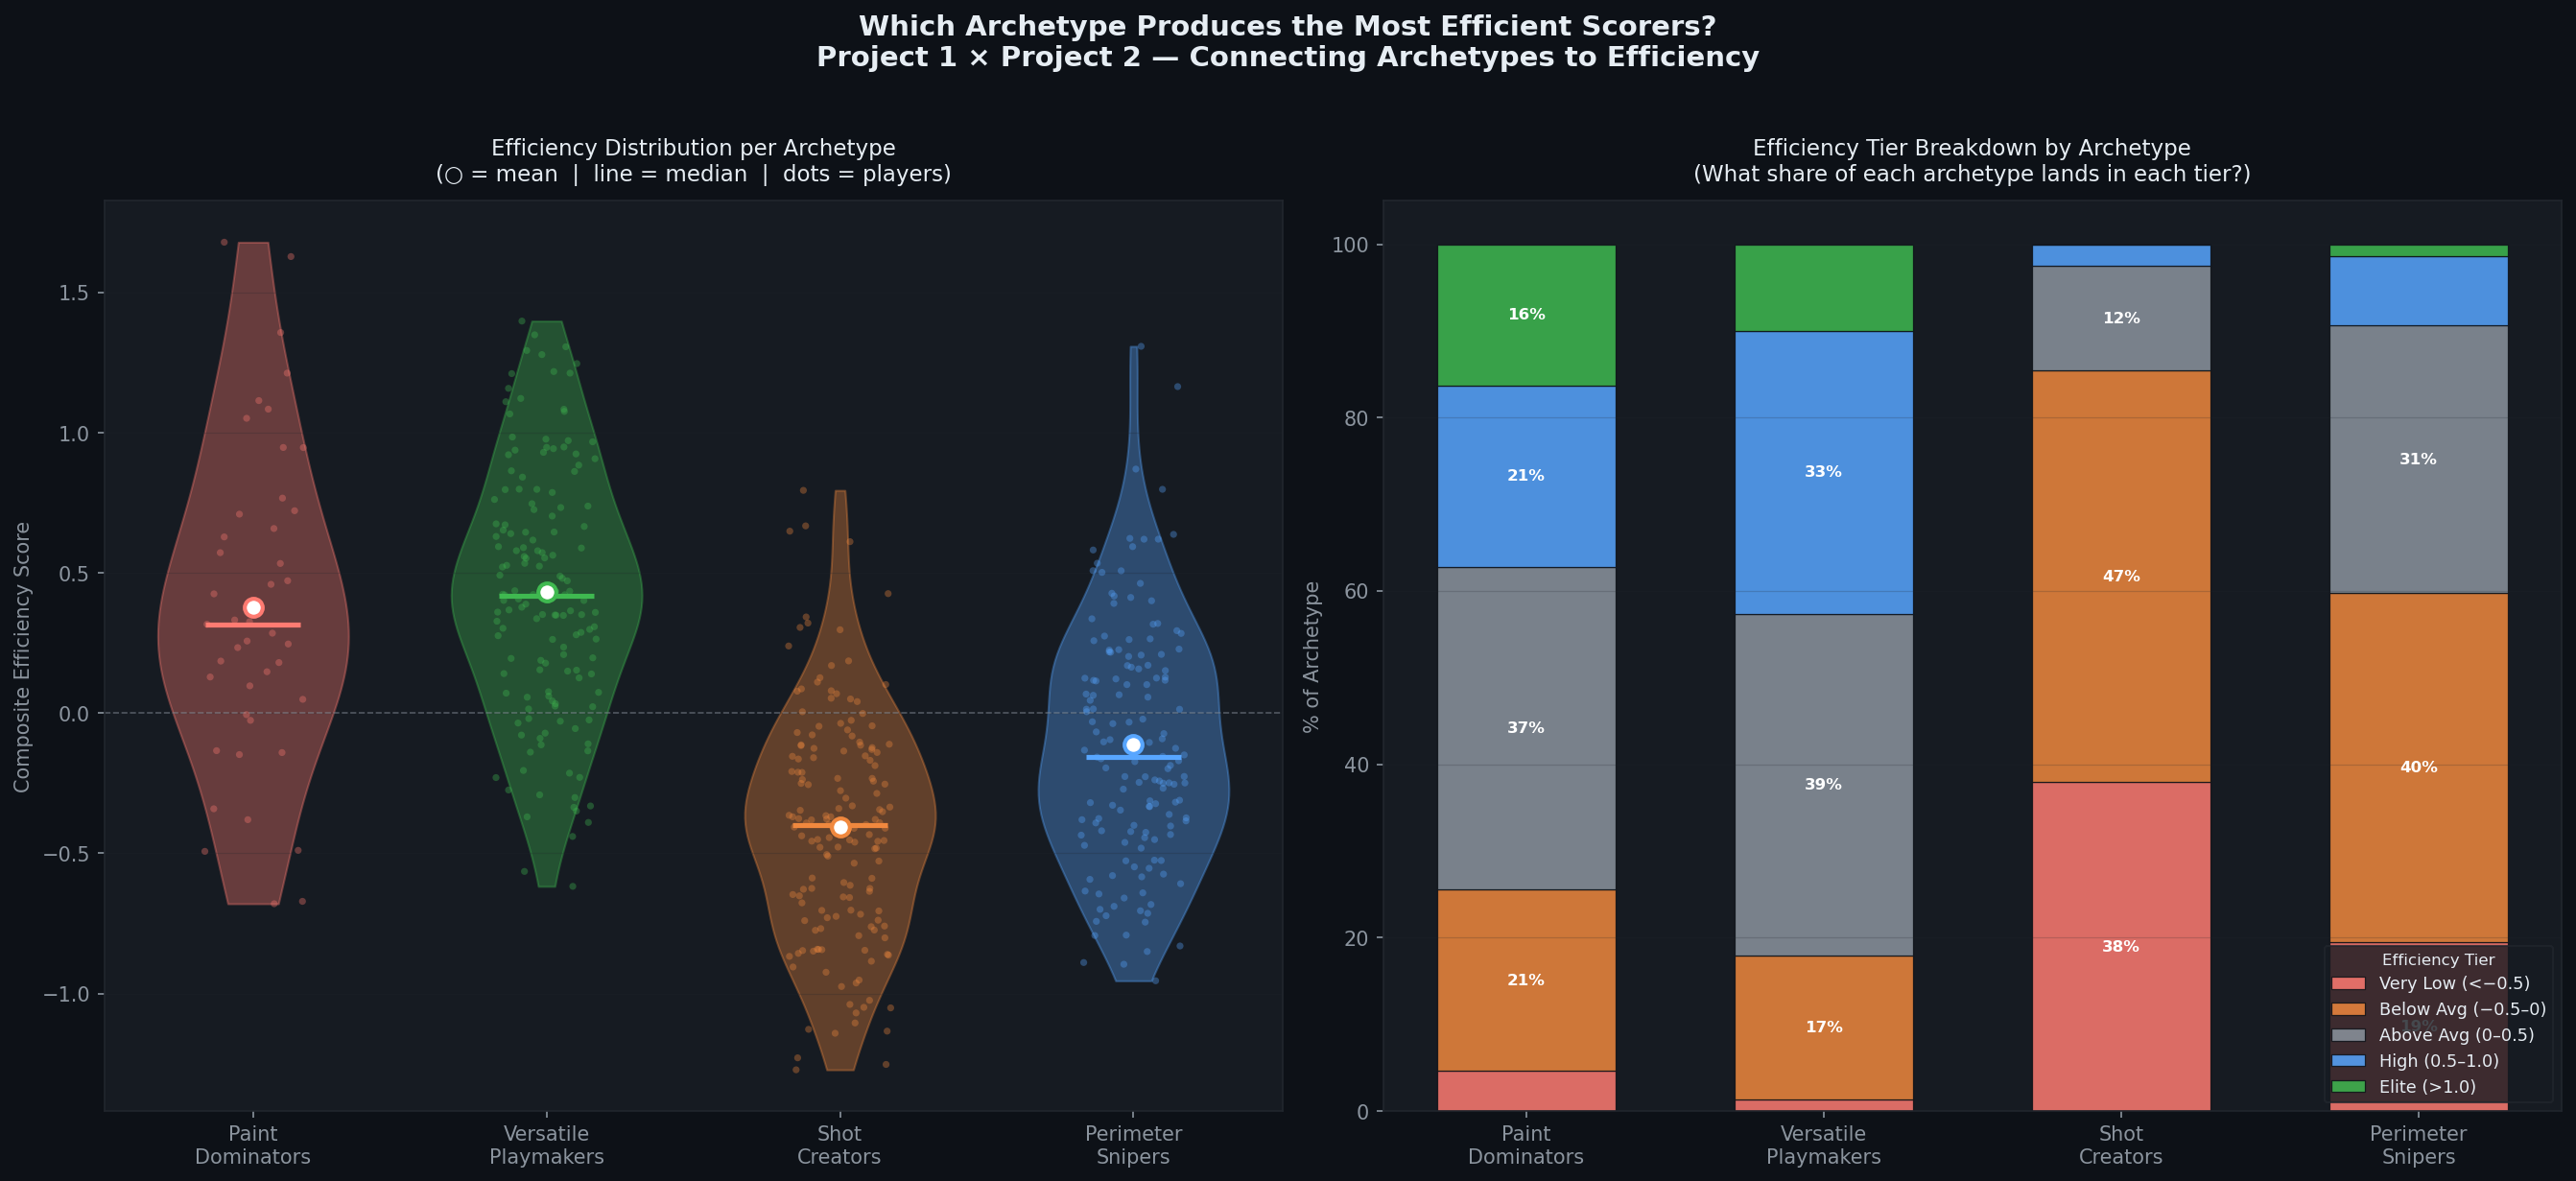

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Which Archetype Produces the Most Efficient Scorers?\n'
             'Project 1 × Project 2 — Connecting Archetypes to Efficiency',
             fontsize=14, fontweight='bold', y=1.02)

archetype_order = ['Paint Dominators','Versatile Playmakers','Shot Creators','Perimeter Snipers']

# ── Violin + jitter ──────────────────────────────────────────────────────────
ax = axes[0]
arch_data   = [df[df['Archetype']==a]['Efficiency_Score'].values for a in archetype_order]
arch_colors = [ARCHETYPE_COLORS[a] for a in archetype_order]
vp = ax.violinplot(arch_data, positions=range(4), widths=0.65,
                   showmedians=True, showextrema=False)
for body, color in zip(vp['bodies'], arch_colors):
    body.set_facecolor(color); body.set_alpha(0.35); body.set_edgecolor(color)
vp['cmedians'].set_colors(arch_colors); vp['cmedians'].set_linewidth(2.5)
rng = np.random.default_rng(42)
for i,(data,color) in enumerate(zip(arch_data, arch_colors)):
    jitter = rng.uniform(-0.18, 0.18, len(data))
    ax.scatter(i+jitter, data, color=color, s=12, alpha=0.35, edgecolors='none', zorder=3)
    ax.scatter(i, np.mean(data), color='white', s=80, zorder=5, edgecolors=color, linewidths=2)
ax.axhline(0, color=MUTED, linewidth=0.8, linestyle='--', alpha=0.5)
ax.set_xticks(range(4))
ax.set_xticklabels([a.replace(' ','\n') for a in archetype_order], fontsize=10)
ax.set_ylabel('Composite Efficiency Score', color=MUTED)
ax.set_title('Efficiency Distribution per Archetype\n(○ = mean  |  line = median  |  dots = players)',
             color=TEXT, fontsize=11, pad=10)
ax.grid(True, alpha=0.22, axis='y')

# ── Efficiency tier stacked bars ──────────────────────────────────────────────
ax      = axes[1]
bins    = [-3, -0.5, 0, 0.5, 1.0, 3]
tlabels = ['Very Low (<−0.5)','Below Avg (−0.5–0)','Above Avg (0–0.5)','High (0.5–1.0)','Elite (>1.0)']
tcolors = ['#FF7B72','#F0883E','#8B949E','#58A6FF','#3FB950']
bottoms = np.zeros(4)
for b_lo, b_hi, tlbl, tcol in zip(bins[:-1], bins[1:], tlabels, tcolors):
    pcts = [((df[df['Archetype']==a]['Efficiency_Score']>=b_lo) &
              (df[df['Archetype']==a]['Efficiency_Score']< b_hi)).mean()*100
             for a in archetype_order]
    bars = ax.bar(range(4), pcts, 0.6, bottom=bottoms,
                  color=tcol, alpha=0.85, edgecolor=BG, linewidth=0.6, label=tlbl)
    for i,(pct,bot) in enumerate(zip(pcts, bottoms)):
        if pct > 12:
            ax.text(i, bot+pct/2, f'{pct:.0f}%', ha='center', va='center',
                    fontsize=8, color='white', fontweight='bold')
    bottoms += np.array(pcts)
ax.set_xticks(range(4))
ax.set_xticklabels([a.replace(' ','\n') for a in archetype_order], fontsize=10)
ax.set_ylabel('% of Archetype', color=MUTED)
ax.set_title('Efficiency Tier Breakdown by Archetype\n(What share of each archetype lands in each tier?)',
             color=TEXT, fontsize=11, pad=10)
ax.legend(facecolor=PANEL, edgecolor=GRID, labelcolor=TEXT, fontsize=8.5,
          loc='lower right', title='Efficiency Tier', title_fontsize=8)
ax.grid(True, alpha=0.2, axis='y')
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()

---
# Capstone Visuals — Engagement-First Outputs

The following four visuals are designed as **shareable, LinkedIn-ready outputs** — each built around a specific hook that a non-technical audience can engage with. They are generated from the analysis already run above; no new modelling.

| Visual | Hook | Target viewer |
|--------|------|---------------|
| **Player Report Cards** | A scout-style card for one player per archetype | Fans, coaches, analysts |
| **Efficiency Leaderboard** | What if ESPN ranked by quality, not volume? | Casual fans, debaters |
| **Headline Case Study** | *The box score lies* — Jordan Riley vs. Logan Duncomb | Everyone |

> *These visuals call the standalone script `cbb_final_visuals.py`. Outputs are saved as PNG files in the working directory.*


In [17]:
# Run the capstone visual script
# Generates: final_player_report_cards.png, final_leaderboard.png,
#             final_archetype_efficiency_connector.png, final_case_study.png
import subprocess
result = subprocess.run(['python3', 'cbb_final_visuals.py'], capture_output=True, text=True)
print(result.stdout)
if result.returncode != 0:
    print('STDERR:', result.stderr)


STDERR: Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Apps > Advanced app settings > App execution aliases.



---
# Export — Enriched Dataset

All derived metrics, cluster labels (both k=2 and k=4), and efficiency rankings are exported to a single CSV for downstream use.


In [18]:
export_cols = [
    'Name','College','Position','GP','MIN','PTS','FGM','FGA','FGPct',
    '3PM','3PA','3PPct','FTM','FTA','FTPct','REB','AST','STL','BLK','TO',
    # Derived features
    'TS_pct','PPM','AST_TO','3PA_rate','FTA_rate',
    # Cluster labels
    'Archetype_k2','Archetype',
    # Efficiency index
    'Efficiency_Score','PPG_Rank','Eff_Rank','Rank_Delta'
]
df[export_cols].to_csv('cbb_enriched_final.csv', index=False)
print(f'Exported cbb_enriched_final.csv  ({df.shape[0]} rows × {len(export_cols)} columns)')
df[export_cols].head()

Exported cbb_enriched_final.csv  (500 rows × 31 columns)


,Name,College,Position,GP,MIN,PTS,FGM,FGA,FGPct,3PM,...,PPM,AST_TO,3PA_rate,FTA_rate,Archetype_k2,Archetype,Efficiency_Score,PPG_Rank,Eff_Rank,Rank_Delta
0,AJ Dybantsa,BYU,F,27,33.7,24.9,8.6,16.0,53.3,1.4,...,0.738872,1.379310,0.237500,0.531250,Paint Bruisers,Versatile Playmakers,1.293544,1,8,-7
1,Jordan Riley,ECU,G,26,37.8,23.6,8.4,19.7,42.7,1.0,...,0.624339,0.920000,0.177665,0.421320,Perimeter Snipers,Shot Creators,-0.186932,2,299,-297
2,P.J. Haggerty,KSU,G,27,34.9,23.5,8.7,17.8,49.1,1.4,...,0.673352,1.181818,0.213483,0.376404,Paint Bruisers,Versatile Playmakers,0.351422,3,132,-129
3,Daeshun Ruffin,JKST,G,24,33.6,23.5,7.3,16.5,44.3,1.5,...,0.699405,1.435897,0.272727,0.533333,Perimeter Snipers,Versatile Playmakers,0.884637,3,39,-36
4,Cameron Boozer,DUKE,F,27,32.8,22.6,8.1,14.0,58.2,1.5,...,0.689024,1.739130,0.264286,0.450000,Paint Bruisers,Versatile Playmakers,1.349361,5,5,0


---
# Summary & Next Steps

## What This Notebook Demonstrates

| Project | Method | Key Finding |
|---------|--------|-------------|
| **1a: k=2 Clustering** | K-Means + elbow/silhouette | Two fundamental archetypes: Paint Bruisers vs. Perimeter Snipers |
| **1b: k=4 Override** | Analyst-driven decision | Four richer archetypes expose distinct sub-profiles within each k=2 group |
| **2: Efficiency Index** | Composite Z-score + rank delta | 297-rank gap between Jordan Riley's PPG rank and efficiency rank — the box score can deceive |
| **Connector** | Cross-project bridge | Versatile Playmakers have the tightest, highest efficiency distribution — the archetype to target |

## Methodological Takeaways Worth Highlighting

- **Follow the algorithm — then evaluate it.** Running the elbow/silhouette before deciding on k is not a waste of time. It establishes a truthful baseline and makes the analyst override credible rather than arbitrary.
- **Document every override.** The k=2→k=4 decision is more interesting in the write-up *because* we showed both. Hiding the statistical result would have been intellectually dishonest and analytically weaker.
- **Feature engineering is where the insight lives.** TS%, PPM, 3PA rate — none of these appear in a box score. Every meaningful finding in this notebook comes from derived features, not raw data.

## Potential Extensions

1. **Conference-adjusted efficiency** — Normalise scores by opponent strength to level the Power vs. mid-major playing field.
2. **Temporal analysis** — Track efficiency trends across the season. Who is peaking heading into March?
3. **Draft prospect overlay** — Cross-reference with mock draft boards. Are NBA scouts correctly valuing efficiency?
4. **Team archetype composition** — Do teams built around one archetype outperform mixed rosters?
5. **Hierarchical clustering at k=5/6** — Use a dendrogram to see if a natural 5th archetype (e.g., elite stretch-4s) emerges without forcing it.

---
*Data: ESPN 2025-26 Men's College Basketball, scraped 2026-02-23 · Python 3 · pandas · scikit-learn · matplotlib*
